# Import Libraries

In [1]:
import sys
sys.path.append("..")
import seaborn as sb
import dgl
import torch

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tqdm import tqdm
import torch.nn.functional as F

import statistics
import argparse
import random

from dgl.data import CitationGraphDataset
# from dgl.nn import GINConv, GraphConv, SAGEConv
import seaborn as sb
import torch
import torch.nn as nn
from torch.autograd import Variable
from scipy.optimize import linear_sum_assignment
import scipy
import scipy.optimize
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn as sk
import networkx as nx


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import random
import math


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data

from torch_geometric.nn import GCNConv,GINConv,SAGEConv,GATConv,PNAConv, GraphSAGE
from torch_geometric.utils import add_self_loops
from torch_geometric.transforms import normalize_features
from pygod.utils import load_data
from pygod.utils.utility import check_parameter
from pygod.metrics import eval_roc_auc
from pygod.generator import gen_contextual_outliers, gen_structural_outliers
from scipy.linalg import sqrtm

/home/roy206/.conda/envs/cent7/2020.11-py38/NWRGAE/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

In [2]:

def _normalize(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min)/x_max
    return x_norm

def gen_joint_structural_outliers(data, m, n, random_state=None):
    """
    We randomly select n nodes from the network which will be the anomalies 
    and for each node we select m nodes from the network. 
    We connect each of n nodes with the m other nodes.

    Parameters
    ----------
    data : PyTorch Geometric Data instance (torch_geometric.data.Data)
        The input data.
    m : int
        Number nodes in the outlier cliques.
    n : int
        Number of outlier cliques.
    p : int, optional
        Probability of edge drop in cliques. Default: ``0``.
    random_state : int, optional
        The seed to control the randomness, Default: ``None``.

    Returns
    -------
    data : PyTorch Geometric Data instance (torch_geometric.data.Data)
        The structural outlier graph with injected edges.
    y_outlier : torch.Tensor
        The outlier label tensor where 1 represents outliers and 0 represents
        regular nodes.
    """

    if not isinstance(data, Data):
        raise TypeError("data should be torch_geometric.data.Data")

    if isinstance(m, int):
        check_parameter(m, low=0, high=data.num_nodes, param_name='m')
    else:
        raise ValueError("m should be int, got %s" % m)

    if isinstance(n, int):
        check_parameter(n, low=0, high=data.num_nodes, param_name='n')
    else:
        raise ValueError("n should be int, got %s" % n)

    check_parameter(m * n, low=0, high=data.num_nodes, param_name='m*n')

    if random_state:
        np.random.seed(random_state)


    outlier_idx = np.random.choice(data.num_nodes, size=n, replace=False)
    all_nodes = [i for i in range(data.num_nodes)]
    rem_nodes = []
    
    for node in all_nodes:
        if node is not outlier_idx:
            rem_nodes.append(node)
    
    
    
    new_edges = []
    
    # connect all m nodes in each clique
    for i in range(0, n):
        other_idx = np.random.choice(data.num_nodes, size=m, replace=False)
        for j in other_idx:
            new_edges.append(torch.tensor([[i, j]], dtype=torch.long))
                    

    new_edges = torch.cat(new_edges)


    y_outlier = torch.zeros(data.x.shape[0], dtype=torch.long)
    y_outlier[outlier_idx] = 1

    data.edge_index = torch.cat([data.edge_index, new_edges.T], dim=1)

    return data, y_outlier


def KL_neighbor_loss(predictions, targets, mask_len):
    x1 = predictions.squeeze().cpu().detach()
    x2 = targets.squeeze().cpu().detach()
    
    mean_x1 = x1.mean(0)
    mean_x2 = x2.mean(0)
    
    nn = x1.shape[0]
    h_dim = x1.shape[1]
    
    cov_x1 = (x1-mean_x1).transpose(1,0).matmul(x1-mean_x1) / max((nn-1),1)
    cov_x2 = (x2-mean_x2).transpose(1,0).matmul(x2-mean_x2) / max((nn-1),1)
    
    eye = torch.eye(h_dim)
    cov_x1 = cov_x1 + eye
    cov_x2 = cov_x2 + eye
    
    KL_loss = 0.5 * (math.log(torch.det(cov_x1) / torch.det(cov_x2)) - h_dim  + torch.trace(torch.inverse(cov_x2).matmul(cov_x1)) 
            + (mean_x2 - mean_x1).reshape(1,-1).matmul(torch.inverse(cov_x2)).matmul(mean_x2 - mean_x1))
    KL_loss = KL_loss.to(device)
    return KL_loss

def W2_neighbor_loss(predictions, targets, mask_len):
    
    x1 = predictions.squeeze().cpu().detach()
    x2 = targets.squeeze().cpu().detach()
    
    mean_x1 = x1.mean(0)
    mean_x2 = x2.mean(0)

    nn = x1.shape[0]
    
    cov_x1 = (x1-mean_x1).transpose(1,0).matmul(x1-mean_x1) / (nn-1)
    cov_x2 = (x2-mean_x2).transpose(1,0).matmul(x2-mean_x2) / (nn-1)
    

    W2_loss = torch.square(mean_x1-mean_x2).sum() + torch.trace(cov_x1 + cov_x2 
                     + 2 * sqrtm(sqrtm(cov_x1) @ (cov_x2.numpy()) @ (sqrtm(cov_x1))))

    return W2_loss



# Layers

In [3]:
class MLP(nn.Module):
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim):
        

        super(MLP, self).__init__()

        self.linear_or_not = True  # default is linear model
        self.num_layers = num_layers

        if num_layers < 1:
            raise ValueError("number of layers should be positive!")
        elif num_layers == 1:
            # Linear model
            self.linear = nn.Linear(input_dim, output_dim)
        else:
            # Multi-layer model
            self.linear_or_not = False
            self.linears = torch.nn.ModuleList()
            self.batch_norms = torch.nn.ModuleList()

            self.linears.append(nn.Linear(input_dim, hidden_dim))
            for layer in range(num_layers - 2):
                self.linears.append(nn.Linear(hidden_dim, hidden_dim))
            self.linears.append(nn.Linear(hidden_dim, output_dim))

            for layer in range(num_layers - 1):
                self.batch_norms.append(nn.BatchNorm1d((hidden_dim)))

    def forward(self, x):
        if self.linear_or_not:
            # If linear model
            return self.linear(x)
        else:
            # If MLP
            h = x
            for layer in range(self.num_layers - 1):
                h = self.linears[layer](h)
                
                if len(h.shape) > 2:
                    h = torch.transpose(h, 0, 1)
                    h = torch.transpose(h, 1, 2)
                    
                h = self.batch_norms[layer](h)
                
                if len(h.shape) > 2:
                    h = torch.transpose(h, 1, 2)
                    h = torch.transpose(h, 0, 1)

                h = F.relu(h)
                # h = F.relu(self.linears[layer](h))
                
            return self.linears[self.num_layers - 1](h)


class MLP_generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP_generator, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.linear3 = nn.Linear(output_dim, output_dim)
        self.linear4 = nn.Linear(output_dim, output_dim)

    def forward(self, embedding):
        neighbor_embedding = F.relu(self.linear(embedding))
        neighbor_embedding = F.relu(self.linear2(neighbor_embedding))
        neighbor_embedding = F.relu(self.linear3(neighbor_embedding))
        neighbor_embedding = self.linear4(neighbor_embedding)
        return neighbor_embedding


class PairNorm(nn.Module):
    def __init__(self, mode='PN', scale=10):
        
        assert mode in ['None', 'PN', 'PN-SI', 'PN-SCS']
        super(PairNorm, self).__init__()
        self.mode = mode
        self.scale = scale

        # Scale can be set based on origina data, and also the current feature lengths.
        # We leave the experiments to future. A good pool we used for choosing scale:
        # [0.1, 1, 10, 50, 100]
    def forward(self, x):
        if self.mode == 'None':
            return x
        col_mean = x.mean(dim=0)
        if self.mode == 'PN':
            x = x - col_mean
            rownorm_mean = (1e-6 + x.pow(2).sum(dim=1).mean()).sqrt()
            x = self.scale * x / rownorm_mean
        if self.mode == 'PN-SI':
            x = x - col_mean
            rownorm_individual = (1e-6 + x.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x = self.scale * x / rownorm_individual
        if self.mode == 'PN-SCS':
            rownorm_individual = (1e-6 + x.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x = self.scale * x / rownorm_individual - col_mean
        return x


# FNN
class FNN(nn.Module):
    def __init__(self, in_features, hidden, out_features, layer_num):
        super(FNN, self).__init__()
        self.linear1 = MLP(layer_num, in_features, hidden, out_features)
        self.linear2 = nn.Linear(out_features, out_features)
    def forward(self, embedding):
        x = self.linear1(embedding)
        x = self.linear2(F.relu(x))
        x = F.relu(x)
        return x


# GAD-NR

In [4]:

# Training
def train(data, y, yc, ys, yj, ysj, lr, epoch, device, encoder, lambda_loss1, lambda_loss2, lambda_loss3, hidden_dim, sample_size=10,loss_step=20,
          real_loss=False,calculate_contextual=False,calculate_structural=False):
    '''
     Main training function
     INPUT:
     -----------------------
     data : torch geometric dataset object
     lr    :    learning rate
     epoch     :    number of training epoch
     device     :   CPU or GPU
     encoder    :    GCN or GIN or GraphSAGE
     lambda_loss    :   Trade-off between degree loss and neighborhood reconstruction loss
     hidden_dim     :   latent variable dimension
    '''
    
    in_nodes = data.edge_index[0,:]
    out_nodes = data.edge_index[1,:]
    
    
    neighbor_dict = {}
    for in_node, out_node in zip(in_nodes, out_nodes):
        if in_node.item() not in neighbor_dict:
            neighbor_dict[in_node.item()] = []
        neighbor_dict[in_node.item()].append(out_node.item())

    neighbor_num_list = []
    for i in neighbor_dict:
        neighbor_num_list.append(len(neighbor_dict[i]))
    
    neighbor_num_list = torch.tensor(neighbor_num_list).to(device)
    
    in_dim = data.x.shape[1]
    GNNModel = GNNStructEncoder(in_dim, hidden_dim, hidden_dim, 2, sample_size, device=device, 
                    neighbor_num_list=neighbor_num_list, GNN_name=encoder, 
                    lambda_loss1=lambda_loss1, lambda_loss2=lambda_loss2,lambda_loss3=lambda_loss3)
    GNNModel.to(device)
    degree_params = list(map(id, GNNModel.degree_decoder.parameters()))
    base_params = filter(lambda p: id(p) not in degree_params,
                         GNNModel.parameters())

    opt = torch.optim.Adam([{'params': base_params}, {'params': GNNModel.degree_decoder.parameters(), 'lr': 1e-2}],lr=lr, weight_decay=0.0003)
    min_loss = float('inf')
    arg_min_loss_per_node = None
    
    best_auc = 0
    best_auc_contextual = 0
    best_auc_dense_structural = 0
    best_auc_joint_structural = 0
    best_auc_structure_type = 0
    
        
    loss_values = []
    for i in tqdm(range(1,epoch+1,1)):
        
        
        if i%loss_step==0:
            GNNModel.lambda_loss2 = GNNModel.lambda_loss2 + 0.5
            GNNModel.lambda_loss3 = GNNModel.lambda_loss3 / 2
        
        loss,loss_per_node,h_loss,degree_loss,feature_loss = GNNModel(data.edge_index, data.x, neighbor_num_list, neighbor_dict, device=device)
        
        
        
        loss_per_node = loss_per_node.cpu().detach()
        
        h_loss = h_loss.cpu().detach()
        degree_loss = degree_loss.cpu().detach()
        feature_loss = feature_loss.cpu().detach()
        
        h_loss_norm = h_loss / (torch.max(h_loss) - torch.min(h_loss))
        degree_loss_norm = degree_loss / (torch.max(degree_loss) - torch.min(degree_loss))
        feature_loss_norm = feature_loss / (torch.max(feature_loss) - torch.min(feature_loss))
        
        comb_loss = args.h_loss_weight * h_loss_norm + args.degree_loss_weight *  degree_loss_norm + args.feature_loss_weight * feature_loss_norm
        
        if real_loss:
            comp_loss = loss_per_node
        else:
            comp_loss = comb_loss
            
        
        auc_score = eval_roc_auc(y.numpy(), comp_loss.numpy()) * 100
        print("Dataset Name: ",dataset_str, ", AUC Score(benchmark/combined): ", auc_score)
        
        contextual_auc_score = eval_roc_auc(yc.numpy(), comp_loss.numpy()) * 100
        print("Dataset Name: ",dataset_str, ", AUC Score (contextual): ", contextual_auc_score)

        dense_structural_auc_score = eval_roc_auc(ys.numpy(), comp_loss.numpy()) * 100
        print("Dataset Name: ",dataset_str, ", AUC Score (structural): ", dense_structural_auc_score)
        
        joint_type_auc_score = eval_roc_auc(yj.numpy(), comp_loss.numpy()) * 100
        print("Dataset Name: ",dataset_str, ", AUC Score (joint-type): ", joint_type_auc_score)
        
        structure_type_auc_score = eval_roc_auc(ysj.numpy(), comp_loss.numpy()) * 100
        print("Dataset Name: ",dataset_str, ", AUC Score (structure type): ", structure_type_auc_score) 
        
        best_auc = max(best_auc, auc_score)
        best_auc_contextual = max(best_auc_contextual, contextual_auc_score)
        best_auc_dense_structural = max(best_auc_dense_structural, dense_structural_auc_score)
        best_auc_joint_type = max(best_auc_joint_structural, joint_type_auc_score)
        best_auc_structure_type = max(best_auc_structure_type, structure_type_auc_score)
        
        
        
        print("===========================================================================================")
        print("Dataset Name: ",dataset_str, " Best AUC Score(benchmark/combined): ", best_auc)
        
        print("Dataset Name: ",dataset_str, " Best AUC Score (contextual): ", best_auc_contextual)

        
        print("Dataset Name: ",dataset_str, " Best AUC Score (structural): ", best_auc_dense_structural)
        
        
        print("Dataset Name: ",dataset_str, " Best AUC Score (joint-type): ", best_auc_joint_type)
        
        
        print("Dataset Name: ",dataset_str, " Best AUC Score (structure type): ", best_auc_structure_type) 
        print("===========================================================================================")
        
        
        if loss < min_loss:
            min_loss = loss
            arg_min_loss_per_node = loss_per_node
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        
        
        loss = loss.cpu().detach()
        loss_values.append(loss)
        
        
        if args.plot_loss:

            plt.plot(np.array(loss_values), 'r')
            plt.show()
    
    return min_loss.item(), arg_min_loss_per_node.cpu().detach()




def evaluate(model, embeddings, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(embeddings)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)


def train_real_datasets(dataset_str, epoch_num = 10, lr = 5e-6, encoder = "GCN", 
                        lambda_loss1=1e-2, lambda_loss2=1e-3, lambda_loss3=1e-3, sample_size=8, loss_step=20, hidden_dim=None,
                        real_loss=False,calculate_contextual=False,calculate_structural=False):
    
    data = load_data(dataset_str)
    node_features = data.x
    
    if args.normalize_feat:
    
        node_features_min = node_features.min()
        node_features_max = node_features.max()
        node_features = (node_features - node_features_min)/node_features_max
        data.x = node_features
    
    yc = []
    ys = []
    yj = []
    
    if calculate_contextual:
        
        if dataset_str == "inj_cora":
            yc = data.y >> 0 & 1 # contextual outliers
        else:
            data, yc = gen_contextual_outliers(data=data,n=args.contextual_n,k=args.contextual_k)
            
        yc = yc.cpu().detach()
    
    
    if calculate_structural:
        
        if dataset_str == "inj_cora":
            ys = data.y >> 1 & 1 # structural outliers
        else:
            data, ys = gen_structural_outliers(data=data,n=args.structural_n,m=args.structural_m,p=0.2)
            
        ys = ys.cpu().detach()
        data, yj = gen_joint_structural_outliers(data=data,n=args.structural_n,m=args.structural_m)
        
    
    if args.use_combine_outlier:
        data.y = torch.logical_or(ys, yc).int()
        
    ysj = torch.logical_or(ys, yj).int()
    y = data.y.bool()    # binary labels (inlier/outlier)
    y = y.cpu().detach()
    
    edge_index = data.edge_index.cpu()
    
    num_nodes = node_features.shape[0]
    self_edges = torch.tensor([[i for i in range(num_nodes)],[i for i in range(num_nodes)]])
    edge_index = torch.cat([edge_index,self_edges],dim=1)
    data.edge_index = edge_index
    data = data.to(device)
    

    loss, loss_per_node, = train(data, y, yc, ys, yj, ysj, lr=lr, epoch=epoch_num, device=device, encoder=encoder, lambda_loss1=lambda_loss1, 
          lambda_loss2=lambda_loss2, lambda_loss3=lambda_loss3, hidden_dim=hidden_dim, sample_size=sample_size,loss_step=loss_step,
                                 real_loss=real_loss,calculate_contextual=calculate_contextual,calculate_structural=calculate_structural)

In [5]:
# generate ground truth neighbors Hv
def generate_gt_neighbor(neighbor_dict, node_embeddings, neighbor_num_list, in_dim):
    max_neighbor_num = max(neighbor_num_list)
    all_gt_neighbor_embeddings = []
    for i, embedding in enumerate(node_embeddings):
        neighbor_indexes = neighbor_dict[i]
        neighbor_embeddings = []
        for index in neighbor_indexes:
            neighbor_embeddings.append(node_embeddings[index].tolist())
        if len(neighbor_embeddings) < max_neighbor_num:
            for _ in range(max_neighbor_num - len(neighbor_embeddings)):
                neighbor_embeddings.append(torch.zeros(in_dim).tolist())
        all_gt_neighbor_embeddings.append(neighbor_embeddings)
    return all_gt_neighbor_embeddings


# Main Autoencoder structure here
class GNNStructEncoder(nn.Module):
    def __init__(self, in_dim0, in_dim, hidden_dim, layer_num, sample_size, device, neighbor_num_list, 
                 GNN_name="GIN", norm_mode="PN-SCS", norm_scale=20, lambda_loss1=0.01, lambda_loss2=0.001, lambda_loss3=0.0001):
        
        super(GNNStructEncoder, self).__init__()
        
        self.mlp0 = nn.Linear(in_dim0, hidden_dim)
        self.norm = PairNorm(norm_mode, norm_scale)
        self.out_dim = hidden_dim
        self.lambda_loss1 = lambda_loss1
        self.lambda_loss2 = lambda_loss2
        self.lambda_loss3 = lambda_loss3
        # GNN Encoder
        if GNN_name == "GIN":
            self.linear1 = MLP(layer_num, hidden_dim, hidden_dim, hidden_dim)
            self.graphconv1 = GINConv(self.linear1)
            self.linear2 = MLP(layer_num, hidden_dim, hidden_dim, hidden_dim)
            self.graphconv2 = GINConv(self.linear2)
        elif GNN_name == "GCN":
            self.graphconv1 = GCNConv(hidden_dim, hidden_dim)
            self.graphconv2 = GCNConv(hidden_dim, hidden_dim)
        elif GNN_name == "GAT":
            self.graphconv1 = GATConv(hidden_dim, hidden_dim)
            self.graphconv2 = GATConv(hidden_dim, hidden_dim)
        else:
            self.graphconv1 = SAGEConv(hidden_dim, hidden_dim, aggr='sum')
            # self.graphconv2 = SAGEConv(hidden_dim, hidden_dim, aggr='mean')
            
            # self.graphconv1 = GraphSAGE(hidden_dim, hidden_dim, aggr='mean', num_layers=1)
            

        self.neighbor_num_list = neighbor_num_list
        self.tot_node = len(neighbor_num_list)

        self.gaussian_mean = nn.Parameter(
            torch.FloatTensor(sample_size, hidden_dim).uniform_(-0.5 / hidden_dim,
                                                                                     0.5 / hidden_dim)).to(device)
        self.gaussian_log_sigma = nn.Parameter(
            torch.FloatTensor(sample_size, hidden_dim).uniform_(-0.5 / hidden_dim,
                                                                                     0.5 / hidden_dim)).to(device)
        self.m = torch.distributions.Normal(torch.zeros(sample_size, hidden_dim),
                                            torch.ones(sample_size, hidden_dim))
        
        self.m_batched = torch.distributions.Normal(torch.zeros(sample_size, self.tot_node, hidden_dim),
                                            torch.ones(sample_size, self.tot_node, hidden_dim))

        self.m_h = torch.distributions.Normal(torch.zeros(sample_size, hidden_dim),
                                            50* torch.ones(sample_size, hidden_dim))

        # Before MLP Gaussian Means, and std

        self.mlp_gaussian_mean = nn.Parameter(
            torch.FloatTensor(hidden_dim).uniform_(-0.5 / hidden_dim, 0.5 / hidden_dim)).to(device)
        self.mlp_gaussian_log_sigma = nn.Parameter(
            torch.FloatTensor(hidden_dim).uniform_(-0.5 / hidden_dim, 0.5 / hidden_dim)).to(device)
        self.mlp_m = torch.distributions.Normal(torch.zeros(hidden_dim), torch.ones(hidden_dim))

        self.mlp_mean = FNN(hidden_dim, hidden_dim, hidden_dim, 3)
        self.mlp_sigma = FNN(hidden_dim, hidden_dim, hidden_dim, 3)
        self.softplus = nn.Softplus()

        self.mean_agg = SAGEConv(hidden_dim, hidden_dim, aggr='mean', normalize = False)
        # self.mean_agg = GraphSAGE(hidden_dim, hidden_dim, aggr='mean', num_layers=1)
        self.std_agg = PNAConv(hidden_dim, hidden_dim, aggregators=["std"],scalers=["identity"], deg=neighbor_num_list)        
        self.layer1_generator = MLP_generator(hidden_dim, hidden_dim)
        
        # Decoders
        self.degree_decoder = FNN(hidden_dim, hidden_dim, 1, 4)
        self.feature_decoder = FNN(hidden_dim, hidden_dim, in_dim, 3)
        self.degree_loss_func = nn.MSELoss()
        self.feature_loss_func = nn.MSELoss()
        self.pool = mp.Pool(4)
        self.in_dim = in_dim
        self.sample_size = sample_size 
        self.init_projection = FNN(in_dim, hidden_dim, hidden_dim, 1)
        

    def forward_encoder(self, x, edge_index):
        
        # Apply graph convolution and activation, pair-norm to avoid trivial solution
        h0 = self.mlp0(x)
        l1 = self.graphconv1(h0, edge_index)
        return l1, h0
        
        

    # Sample neighbors from neighbor set, if the length of neighbor set less than sample size, then do the padding.
    def sample_neighbors(self, indexes, neighbor_dict, gt_embeddings):
        sampled_embeddings_list = []
        mark_len_list = []
        for index in indexes:
            sampled_embeddings = []
            neighbor_indexes = neighbor_dict[index]
            if len(neighbor_indexes) < self.sample_size:
                mask_len = len(neighbor_indexes)
                sample_indexes = neighbor_indexes
            else:
                sample_indexes = random.sample(neighbor_indexes, self.sample_size)
                mask_len = self.sample_size
            for index in sample_indexes:
                sampled_embeddings.append(gt_embeddings[index].tolist())
            if len(sampled_embeddings) < self.sample_size:
                for _ in range(self.sample_size - len(sampled_embeddings)):
                    sampled_embeddings.append(torch.zeros(self.out_dim).tolist())
            sampled_embeddings_list.append(sampled_embeddings)
            mark_len_list.append(mask_len)
        
        return sampled_embeddings_list, mark_len_list
    
    def reconstruction_neighbors2(self, l1, h0, edge_index):
                
        recon_loss = 0
        recon_loss_per_node = []
    
        sample_sz_per_node = [self.sample_size]* self.tot_node

        # mean_neigh = self.graphconv1(h0, edge_index)
        mean_neigh = self.mean_agg(h0, edge_index).detach()
        std_neigh = self.std_agg(h0, edge_index).detach()
        # mean_neigh = self.graphconv2(mean_neigh, edge_index)
        # mean_neigh = l1
        # mean_neigh = self.mean_agg(h0, edge_index, num_sampled_nodes_per_hop=sample_sz_per_node)
        
        
        cov_neigh = torch.bmm(std_neigh.unsqueeze(dim=-1),std_neigh.unsqueeze(dim=1))
        
        target_mean = mean_neigh
        target_cov = cov_neigh
        
        self_embedding = l1
        # self_embedding = _normalize(self_embedding)
        
        self_embedding = self_embedding.unsqueeze(0)
        self_embedding = self_embedding.repeat(self.sample_size, 1, 1)
        generated_mean = self.mlp_mean(self_embedding)
        generated_sigma = self.mlp_sigma(self_embedding)

        
        std_z = self.m_batched.sample().to(device)
        var = generated_mean + generated_sigma.exp() * std_z
        nhij = self.layer1_generator(var)
        
        generated_mean = torch.mean(nhij,dim=0)
        generated_std = torch.std(nhij,dim=0)
        generated_cov = torch.bmm(generated_std.unsqueeze(dim=-1),generated_std.unsqueeze(dim=1))/self.sample_size
        
        
        tot_nodes = l1.shape[0]
        h_dim = l1.shape[1]
        
        single_eye = torch.eye(h_dim).to(device)
        single_eye = single_eye.unsqueeze(dim=0)
        batch_eye = single_eye.repeat(tot_nodes,1,1)
        
        target_cov = target_cov + batch_eye
        generated_cov = generated_cov + batch_eye

        
        det_target_cov = torch.linalg.det(target_cov) 
        det_generated_cov = torch.linalg.det(generated_cov) 
        trace_mat = torch.matmul(torch.inverse(generated_cov),target_cov)
             
        
        x = torch.bmm(torch.unsqueeze(generated_mean - target_mean,dim=1),torch.inverse(generated_cov))
        y = torch.unsqueeze(generated_mean - target_mean,dim=-1)
        z = torch.bmm(x,y).squeeze()
        
        KL_loss = 0.5 * (torch.log(det_target_cov / det_generated_cov) - h_dim  + trace_mat.diagonal(offset=0, dim1=-1, dim2=-2).sum(-1) + z)
        
        recon_loss = torch.mean(KL_loss)
        recon_loss_per_node = KL_loss
        
        
        return recon_loss, recon_loss_per_node
    
                
        # self_embedding_min = self_embedding.min()
        # self_embedding_max = self_embedding.max()
        # self_embedding = (self_embedding - self_embedding_min)/(self_embedding_max+1e-14)
        # generated_mean = self.mean_generator(self_embedding)
        # generated_mean = _normalize(generated_mean)
        # generated_std = self.std_generator(self_embedding)
        # generated_std = _normalize(generated_std)
        # generated_std = generated_std.abs().squeeze()
        # generated_std = self.softplus(generated_std)
        # generated_std = generated_std.exp().squeeze()
        
        # cov_x1 = (x1-mean_x1).transpose(1,0).matmul(x1-mean_x1) / max((nn-1),1)
        # cov_x2 = (x2-mean_x2).transpose(1,0).matmul(x2-mean_x2) / max((nn-1),1)
        
        # generated_cov = generated_cov + torch.rand(generated_cov.shape).to(device)
        # generated_cov = generated_cov * batch_eye
        
        # print(torch.isfinite(det_target_cov).all())
        # print(torch.isfinite(det_generated_cov).all()) 
        
        # KL_loss = 0.5 * (math.log(torch.det(cov_x1) / torch.det(cov_x2)) - h_dim  + torch.trace(torch.inverse(cov_x2).matmul(cov_x1)) 
        #     + (mean_x2 - mean_x1).reshape(1,-1).matmul(torch.inverse(cov_x2)).matmul(mean_x2 - mean_x1))
    

    def reconstruction_neighbors(self, FNN_generator, neighbor_indexes, neighbor_dict, from_layer, to_layer, device):
        
        
        local_index_loss = 0
        local_index_loss_per_node = []
        sampled_embeddings_list, mark_len_list = self.sample_neighbors(neighbor_indexes, neighbor_dict, to_layer)
        for i, neighbor_embeddings1 in enumerate(sampled_embeddings_list):
            # Generating h^k_v, reparameterization trick
            
            # print(len(neighbor_embeddings1))
            
            index = neighbor_indexes[i]
            mask_len1 = mark_len_list[i]
            mean = from_layer[index].repeat(self.sample_size, 1)
            mean = self.mlp_mean(mean)
            sigma = from_layer[index].repeat(self.sample_size, 1)
            sigma = self.mlp_sigma(sigma)
            std_z = self.m.sample().to(device)
            var = mean + sigma.exp() * std_z
            nhij = FNN_generator(var)
            
            generated_neighbors = nhij
            sum_neighbor_norm = 0
            
            for indexi, generated_neighbor in enumerate(generated_neighbors):
                sum_neighbor_norm += torch.norm(generated_neighbor) / math.sqrt(self.out_dim)
            generated_neighbors = torch.unsqueeze(generated_neighbors, dim=0).to(device)
            target_neighbors = torch.unsqueeze(torch.FloatTensor(neighbor_embeddings1), dim=0).to(device)
            
            if args.neigh_loss == "KL":
                KL_loss = KL_neighbor_loss(generated_neighbors, target_neighbors, mask_len1)
                local_index_loss += KL_loss
                local_index_loss_per_node.append(KL_loss)
            
            else:
                W2_loss = W2_neighbor_loss(generated_neighbors, target_neighbors, mask_len1)
                local_index_loss += W2_loss
                local_index_loss_per_node.append(W2_loss)
            
            
        local_index_loss_per_node = torch.stack(local_index_loss_per_node)
        return local_index_loss, local_index_loss_per_node
    

    def neighbor_decoder(self, gij, ground_truth_degree_matrix, h0, neighbor_dict, device, h, edge_index):
        
        # Degree decoder below:
        tot_nodes = gij.shape[0]
        degree_logits = self.degree_decoding(gij)
        ground_truth_degree_matrix = torch.unsqueeze(ground_truth_degree_matrix, dim=1)
        degree_loss = self.degree_loss_func(degree_logits, ground_truth_degree_matrix.float())
        degree_loss_per_node = (degree_logits-ground_truth_degree_matrix).pow(2)
        _, degree_masks = torch.max(degree_logits.data, dim=1)
        h_loss = 0
        feature_loss = 0
        # layer 1
        loss_list = []
        loss_list_per_node = []
        feature_loss_list = []
        # Sample multiple times to remove noise
        for _ in range(3):
            local_index_loss_sum = 0
            local_index_loss_sum_per_node = []
            indexes = []
            h0_prime = self.feature_decoder(gij)
            feature_losses = self.feature_loss_func(h0, h0_prime)
            feature_losses_per_node = (h0-h0_prime).pow(2).mean(1)
            feature_loss_list.append(feature_losses_per_node)
            

            
            # local_index_loss, local_index_loss_per_node = self.reconstruction_neighbors(self.layer1_generator, indexes, neighbor_dict, gij, h0, device)
            local_index_loss, local_index_loss_per_node = self.reconstruction_neighbors2(gij,h0,edge_index)
            
            # print(local_index_loss, local_index_loss2)
            # print(local_index_loss_per_node, local_index_loss_per_node2)

            loss_list.append(local_index_loss)
            loss_list_per_node.append(local_index_loss_per_node)
            
        loss_list = torch.stack(loss_list)
        h_loss += torch.mean(loss_list)
        
        loss_list_per_node = torch.stack(loss_list_per_node)
        h_loss_per_node = torch.mean(loss_list_per_node,dim=0)
        
        feature_loss_per_node = torch.mean(torch.stack(feature_loss_list),dim=0)
        feature_loss += torch.mean(torch.stack(feature_loss_list))
                
        h_loss_per_node = h_loss_per_node.reshape(tot_nodes,1)
        degree_loss_per_node = degree_loss_per_node.reshape(tot_nodes,1)
        feature_loss_per_node = feature_loss_per_node.reshape(tot_nodes,1)
        
        loss = self.lambda_loss1 * h_loss + degree_loss * self.lambda_loss3 + self.lambda_loss2 * feature_loss
        loss_per_node = self.lambda_loss1 * h_loss_per_node + degree_loss_per_node * self.lambda_loss3 + self.lambda_loss2 * feature_loss_per_node
        

        return loss,loss_per_node,h_loss_per_node,degree_loss_per_node,feature_loss_per_node

    def degree_decoding(self, node_embeddings):
        degree_logits = F.relu(self.degree_decoder(node_embeddings))
        return degree_logits

    def forward(self, edge_index, x, ground_truth_degree_matrix, neighbor_dict, device):
        
        # Generate GNN encodings
        l1, h0 = self.forward_encoder(x, edge_index)
        loss, loss_per_node,h_loss,degree_loss,feature_loss = self.neighbor_decoder(l1, ground_truth_degree_matrix, h0, neighbor_dict, device, x, edge_index)
        
        return loss, loss_per_node,h_loss,degree_loss,feature_loss


# Execution

GAD-NR: Graph Anomaly Detection via Neighborhood Reconstruction
Dataset:  inj_cora lr: 0.01 lambda_loss1 (neighbor): 0.01 lambda_loss2 (feature): 0.1 lambda_loss3 (degree): 0.8 sample_size: 10 dimension: 128 encoder: GCN loss_step: 5000 real_loss: False h_loss_weight: 1.0 feature_loss_weight 2.5 degree_loss_weight: 0 calculate_contextual True calculate_structural True


  0%|          | 0/500 [00:00<?, ?it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  41.597586420797384
Dataset Name:  inj_cora , AUC Score (contextual):  56.091736163760416
Dataset Name:  inj_cora , AUC Score (structural):  26.55258312574461
Dataset Name:  inj_cora , AUC Score (joint-type):  49.550525289721655
Dataset Name:  inj_cora , AUC Score (structure type):  37.997597251120865
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  41.597586420797384
Dataset Name:  inj_cora  Best AUC Score (contextual):  56.091736163760416
Dataset Name:  inj_cora  Best AUC Score (structural):  26.55258312574461
Dataset Name:  inj_cora  Best AUC Score (joint-type):  49.550525289721655
Dataset Name:  inj_cora  Best AUC Score (structure type):  37.997597251120865


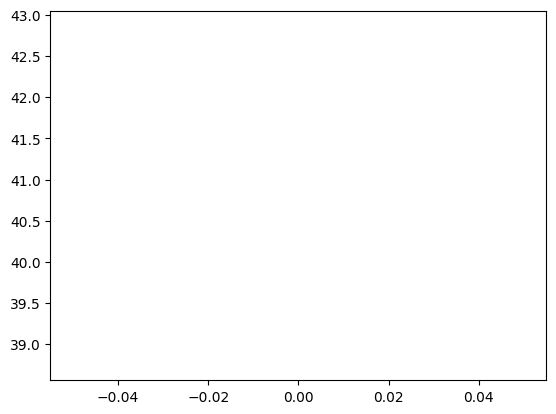

  0%|          | 1/500 [00:00<04:06,  2.02it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  53.604015113066026
Dataset Name:  inj_cora , AUC Score (contextual):  61.49518033141991
Dataset Name:  inj_cora , AUC Score (structural):  45.17870681252031
Dataset Name:  inj_cora , AUC Score (joint-type):  47.04862991443734
Dataset Name:  inj_cora , AUC Score (structure type):  45.78272765205508
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  53.604015113066026
Dataset Name:  inj_cora  Best AUC Score (contextual):  61.49518033141991
Dataset Name:  inj_cora  Best AUC Score (structural):  45.17870681252031
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.04862991443734
Dataset Name:  inj_cora  Best AUC Score (structure type):  45.78272765205508


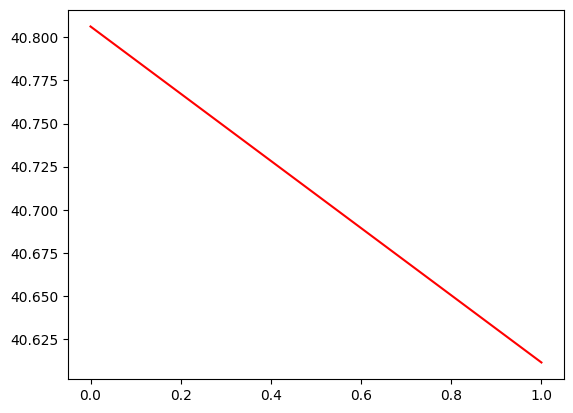

  0%|          | 2/500 [00:00<04:02,  2.05it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  62.1639034568319
Dataset Name:  inj_cora , AUC Score (contextual):  77.30937939997833
Dataset Name:  inj_cora , AUC Score (structural):  46.91757825192245
Dataset Name:  inj_cora , AUC Score (joint-type):  46.254196902415245
Dataset Name:  inj_cora , AUC Score (structure type):  46.419820157886925
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  62.1639034568319
Dataset Name:  inj_cora  Best AUC Score (contextual):  77.30937939997833
Dataset Name:  inj_cora  Best AUC Score (structural):  46.91757825192245
Dataset Name:  inj_cora  Best AUC Score (joint-type):  46.254196902415245
Dataset Name:  inj_cora  Best AUC Score (structure type):  46.419820157886925


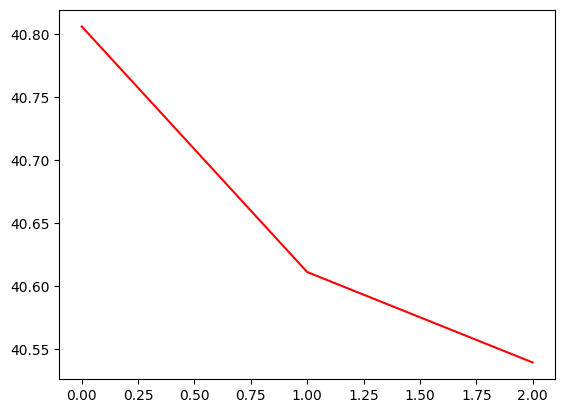

  1%|          | 3/500 [00:01<04:01,  2.06it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora , AUC Score (contextual):  81.05870248023395
Dataset Name:  inj_cora , AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora , AUC Score (joint-type):  49.001949528863854
Dataset Name:  inj_cora , AUC Score (structure type):  52.60563833868678
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  81.05870248023395
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  49.001949528863854
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


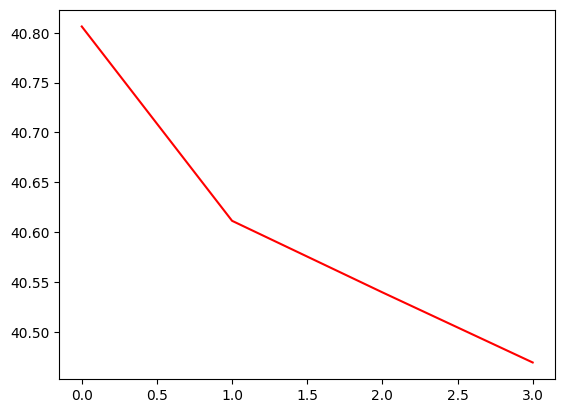

  1%|          | 4/500 [00:01<04:00,  2.06it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  68.51632549484012
Dataset Name:  inj_cora , AUC Score (contextual):  81.07928084046355
Dataset Name:  inj_cora , AUC Score (structural):  55.73757175349291
Dataset Name:  inj_cora , AUC Score (joint-type):  49.681035416441034
Dataset Name:  inj_cora , AUC Score (structure type):  52.56223203609165
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  81.07928084046355
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  49.681035416441034
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


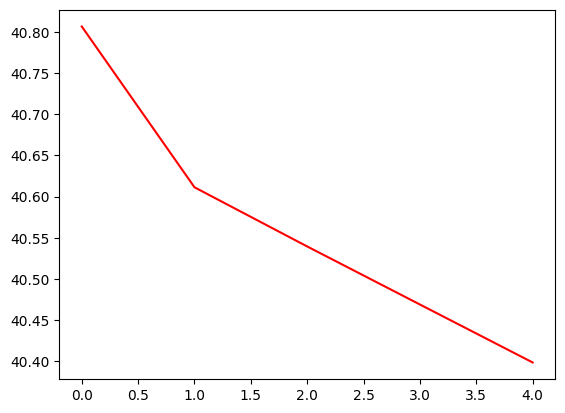

  1%|          | 5/500 [00:02<04:01,  2.05it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  66.97654091242316
Dataset Name:  inj_cora , AUC Score (contextual):  80.72511643019604
Dataset Name:  inj_cora , AUC Score (structural):  53.09162785660132
Dataset Name:  inj_cora , AUC Score (joint-type):  50.259937181847725
Dataset Name:  inj_cora , AUC Score (structure type):  51.51067935064171
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  81.07928084046355
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  50.259937181847725
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


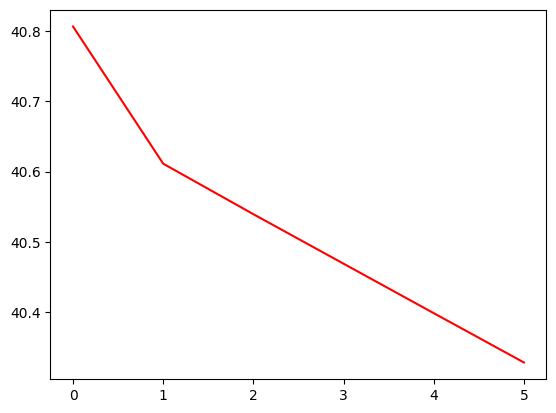

  1%|          | 6/500 [00:02<03:58,  2.07it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  65.84306095979248
Dataset Name:  inj_cora , AUC Score (contextual):  80.94768764215314
Dataset Name:  inj_cora , AUC Score (structural):  50.6460522040507
Dataset Name:  inj_cora , AUC Score (joint-type):  50.14594389689159
Dataset Name:  inj_cora , AUC Score (structure type):  50.20779017113285
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  81.07928084046355
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  50.14594389689159
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


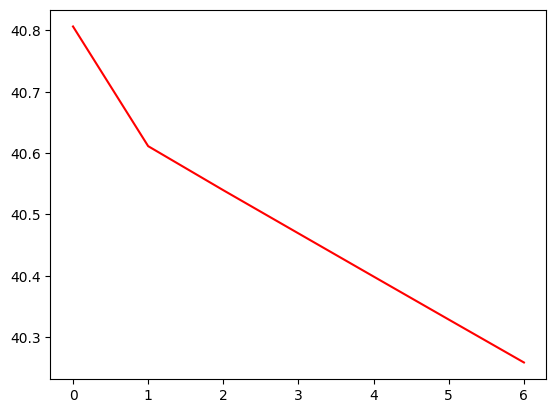

  1%|▏         | 7/500 [00:03<03:56,  2.09it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  65.20695877742064
Dataset Name:  inj_cora , AUC Score (contextual):  81.45294053936965
Dataset Name:  inj_cora , AUC Score (structural):  48.934257554424356
Dataset Name:  inj_cora , AUC Score (joint-type):  49.52886385790101
Dataset Name:  inj_cora , AUC Score (structure type):  49.021677947638
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  81.45294053936965
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  49.52886385790101
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


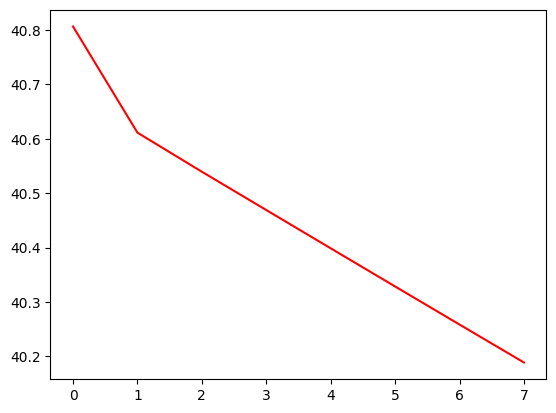

  2%|▏         | 8/500 [00:03<03:56,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  65.454942762082
Dataset Name:  inj_cora , AUC Score (contextual):  82.42553882811654
Dataset Name:  inj_cora , AUC Score (structural):  48.46122603704105
Dataset Name:  inj_cora , AUC Score (joint-type):  49.28733889310084
Dataset Name:  inj_cora , AUC Score (structure type):  48.6642060427174
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  82.42553882811654
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  49.28733889310084
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


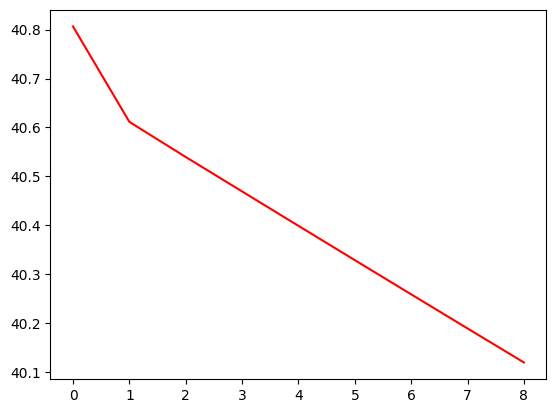

  2%|▏         | 9/500 [00:04<03:57,  2.07it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  65.07880787232843
Dataset Name:  inj_cora , AUC Score (contextual):  83.30932524639879
Dataset Name:  inj_cora , AUC Score (structural):  46.84420015163002
Dataset Name:  inj_cora , AUC Score (joint-type):  48.840571861800065
Dataset Name:  inj_cora , AUC Score (structure type):  47.63589673220552
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  83.30932524639879
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.840571861800065
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


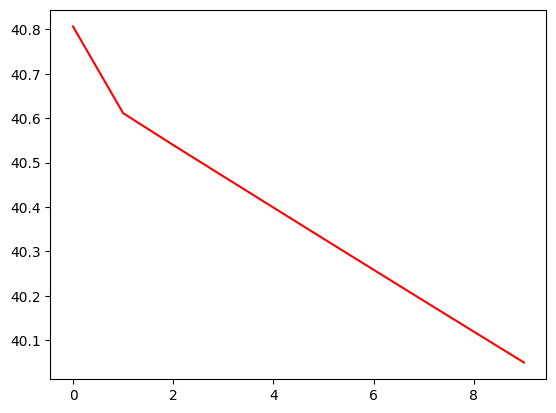

  2%|▏         | 10/500 [00:04<03:57,  2.06it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.67800146619297
Dataset Name:  inj_cora , AUC Score (contextual):  83.3975955810679
Dataset Name:  inj_cora , AUC Score (structural):  46.0034658290913
Dataset Name:  inj_cora , AUC Score (joint-type):  48.11166468103542
Dataset Name:  inj_cora , AUC Score (structure type):  46.811317003228865
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  83.3975955810679
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.11166468103542
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


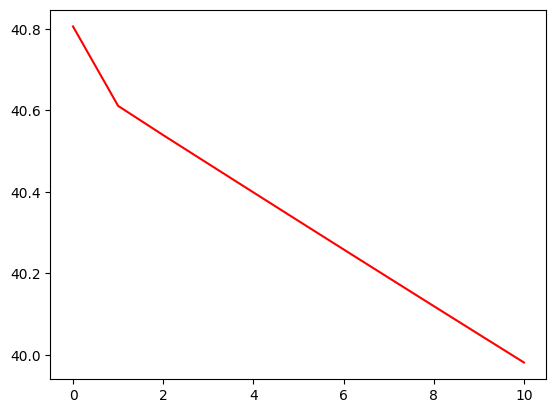

  2%|▏         | 11/500 [00:05<03:55,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.8013590481024
Dataset Name:  inj_cora , AUC Score (contextual):  83.20047655150007
Dataset Name:  inj_cora , AUC Score (structural):  46.44833748510777
Dataset Name:  inj_cora , AUC Score (joint-type):  47.6161594281382
Dataset Name:  inj_cora , AUC Score (structure type):  46.762729948388504
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  83.3975955810679
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.6161594281382
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


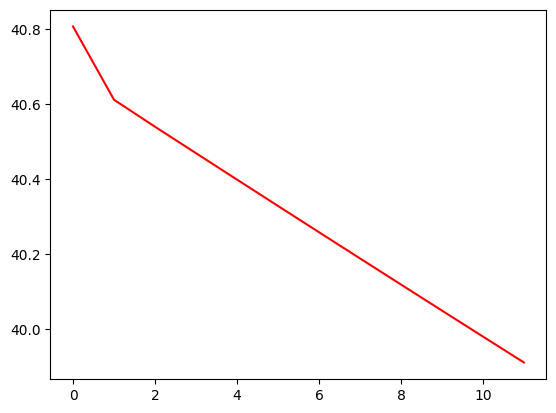

  2%|▏         | 12/500 [00:05<03:55,  2.07it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.22968476851068
Dataset Name:  inj_cora , AUC Score (contextual):  83.44037690891368
Dataset Name:  inj_cora , AUC Score (structural):  45.071482725008124
Dataset Name:  inj_cora , AUC Score (joint-type):  47.710386656558
Dataset Name:  inj_cora , AUC Score (structure type):  46.09357278676865
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  83.44037690891368
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.710386656558
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


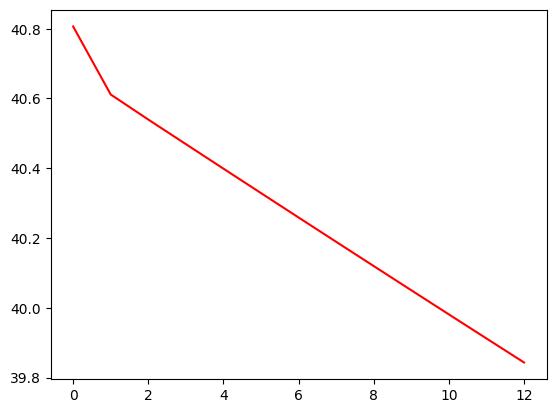

  3%|▎         | 13/500 [00:06<03:54,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.49303558337563
Dataset Name:  inj_cora , AUC Score (contextual):  83.42142315607062
Dataset Name:  inj_cora , AUC Score (structural):  45.61301852052421
Dataset Name:  inj_cora , AUC Score (joint-type):  48.166359796382544
Dataset Name:  inj_cora , AUC Score (structure type):  46.57244231862466
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  83.44037690891368
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.166359796382544
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


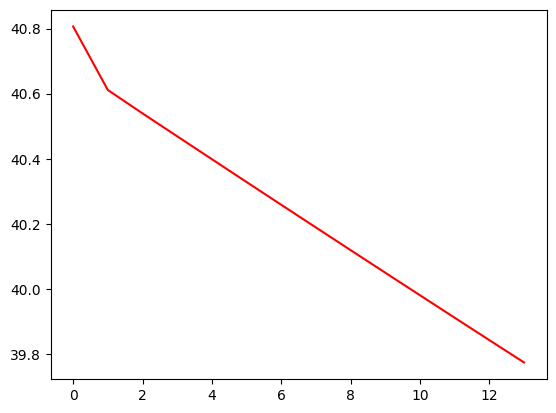

  3%|▎         | 14/500 [00:06<03:53,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.22235380364292
Dataset Name:  inj_cora , AUC Score (contextual):  83.41330011913787
Dataset Name:  inj_cora , AUC Score (structural):  45.096934907397376
Dataset Name:  inj_cora , AUC Score (joint-type):  48.061031084154656
Dataset Name:  inj_cora , AUC Score (structure type):  46.247455130484944
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  83.44037690891368
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.061031084154656
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


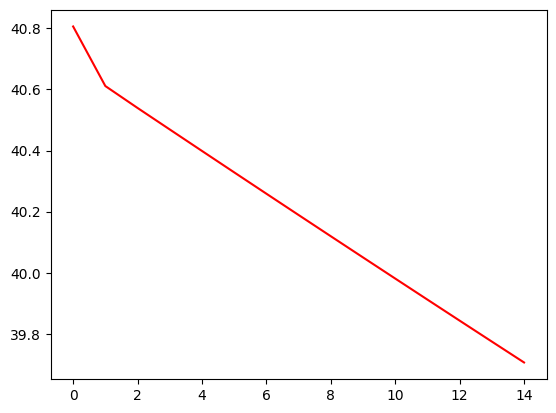

  3%|▎         | 15/500 [00:07<03:53,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.22658320645125
Dataset Name:  inj_cora , AUC Score (contextual):  83.41330011913787
Dataset Name:  inj_cora , AUC Score (structural):  45.10668255171667
Dataset Name:  inj_cora , AUC Score (joint-type):  48.10354164410268
Dataset Name:  inj_cora , AUC Score (structure type):  46.280919989582486
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  83.44037690891368
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.10354164410268
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


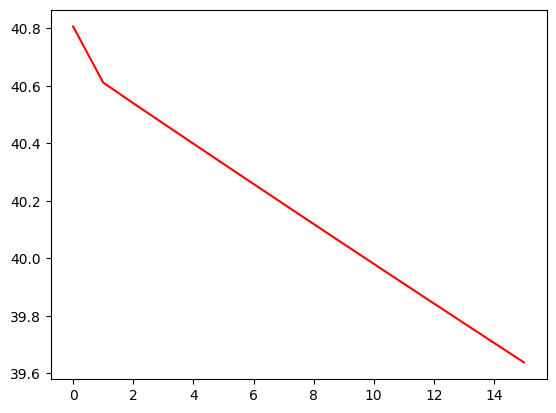

  3%|▎         | 16/500 [00:07<03:53,  2.07it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  65.11955111938194
Dataset Name:  inj_cora , AUC Score (contextual):  83.2995776020795
Dataset Name:  inj_cora , AUC Score (structural):  46.97389797465612
Dataset Name:  inj_cora , AUC Score (joint-type):  48.39922018845445
Dataset Name:  inj_cora , AUC Score (structure type):  47.38091970954183
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  83.44037690891368
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.39922018845445
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


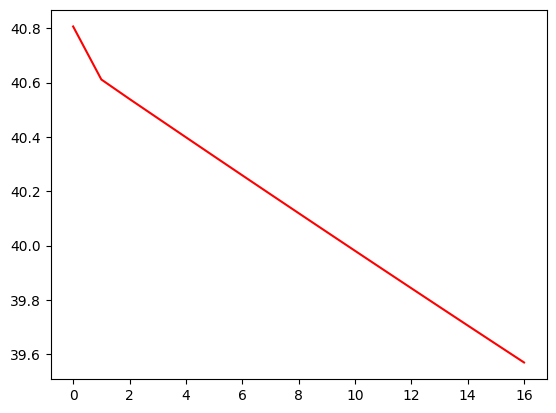

  3%|▎         | 17/500 [00:08<03:52,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  65.3527321942142
Dataset Name:  inj_cora , AUC Score (contextual):  83.36077114697281
Dataset Name:  inj_cora , AUC Score (structural):  47.3703021769739
Dataset Name:  inj_cora , AUC Score (joint-type):  48.68785876746452
Dataset Name:  inj_cora , AUC Score (structure type):  47.736291309498135
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  83.44037690891368
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.68785876746452
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


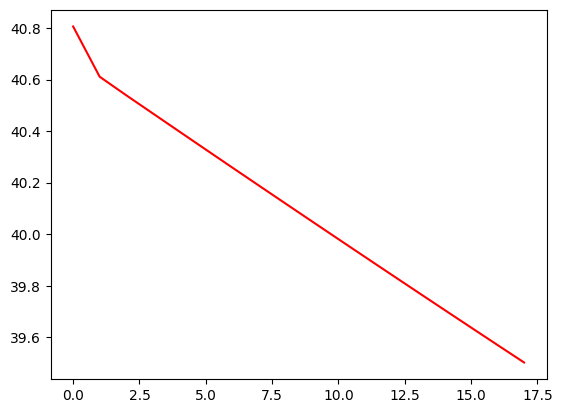

  4%|▎         | 18/500 [00:08<03:52,  2.07it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.92584447076072
Dataset Name:  inj_cora , AUC Score (contextual):  83.52756417199177
Dataset Name:  inj_cora , AUC Score (structural):  46.37658399220188
Dataset Name:  inj_cora , AUC Score (joint-type):  48.36645727282573
Dataset Name:  inj_cora , AUC Score (structure type):  47.060133131330666
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  83.52756417199177
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.36645727282573
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


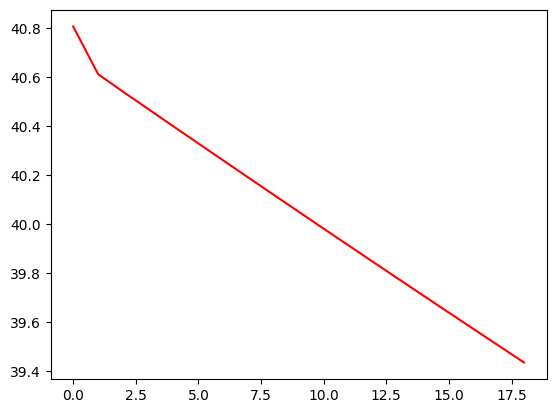

  4%|▍         | 19/500 [00:09<03:52,  2.07it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.62301922968476
Dataset Name:  inj_cora , AUC Score (contextual):  83.83407343225387
Dataset Name:  inj_cora , AUC Score (structural):  45.48738221596448
Dataset Name:  inj_cora , AUC Score (joint-type):  47.79432470486299
Dataset Name:  inj_cora , AUC Score (structure type):  46.315084950334786
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  83.83407343225387
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.79432470486299
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


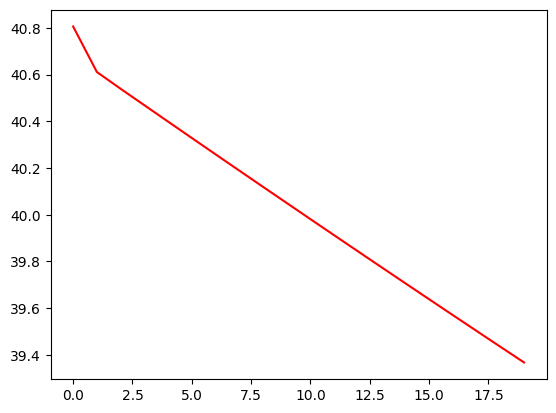

  4%|▍         | 20/500 [00:09<03:53,  2.06it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.88721592511138
Dataset Name:  inj_cora , AUC Score (contextual):  84.05881078739304
Dataset Name:  inj_cora , AUC Score (structural):  45.77710386656558
Dataset Name:  inj_cora , AUC Score (joint-type):  47.69089136791943
Dataset Name:  inj_cora , AUC Score (structure type):  46.416459669944075
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.05881078739304
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.69089136791943
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


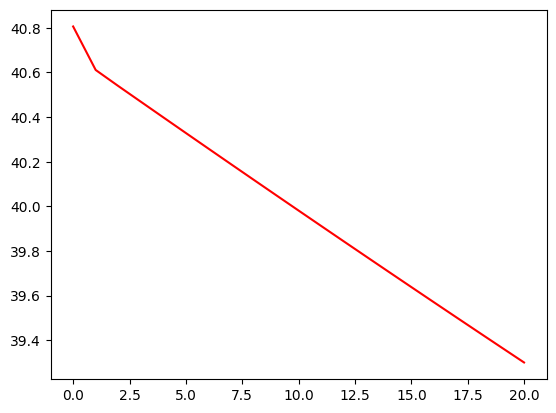

  4%|▍         | 21/500 [00:10<03:54,  2.04it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.76512716404443
Dataset Name:  inj_cora , AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora , AUC Score (structural):  45.36445359038232
Dataset Name:  inj_cora , AUC Score (joint-type):  47.62753167984404
Dataset Name:  inj_cora , AUC Score (structure type):  46.17338437541131
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.62753167984404
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


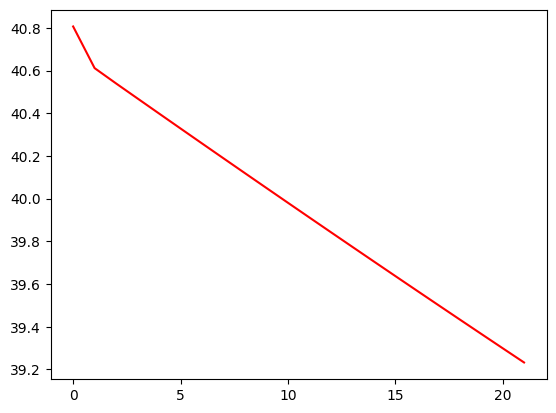

  4%|▍         | 22/500 [00:10<03:52,  2.06it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.69632887836237
Dataset Name:  inj_cora , AUC Score (contextual):  84.22289613343442
Dataset Name:  inj_cora , AUC Score (structural):  45.23556807104949
Dataset Name:  inj_cora , AUC Score (joint-type):  47.622116321888875
Dataset Name:  inj_cora , AUC Score (structure type):  46.105334494568616
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.622116321888875
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


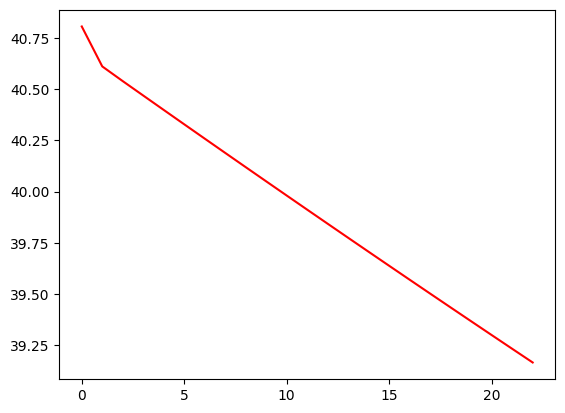

  5%|▍         | 23/500 [00:11<03:51,  2.06it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.12902498167259
Dataset Name:  inj_cora , AUC Score (contextual):  84.14329037149356
Dataset Name:  inj_cora , AUC Score (structural):  44.21531463229719
Dataset Name:  inj_cora , AUC Score (joint-type):  47.221921369002494
Dataset Name:  inj_cora , AUC Score (structure type):  45.36490698449415
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.221921369002494
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


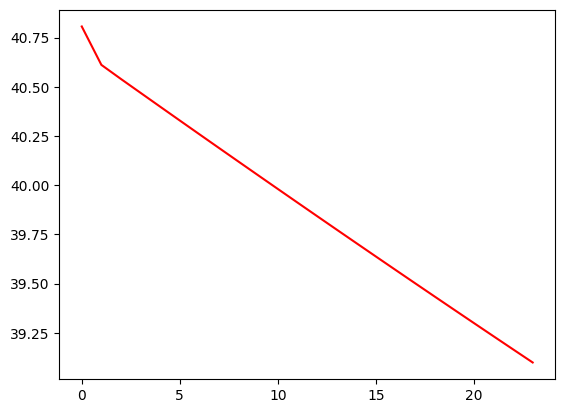

  5%|▍         | 24/500 [00:11<03:49,  2.07it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.2623921502284
Dataset Name:  inj_cora , AUC Score (contextual):  84.07180764648542
Dataset Name:  inj_cora , AUC Score (structural):  44.54402686017546
Dataset Name:  inj_cora , AUC Score (joint-type):  47.416332719592766
Dataset Name:  inj_cora , AUC Score (structure type):  45.62926536933163
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.416332719592766
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


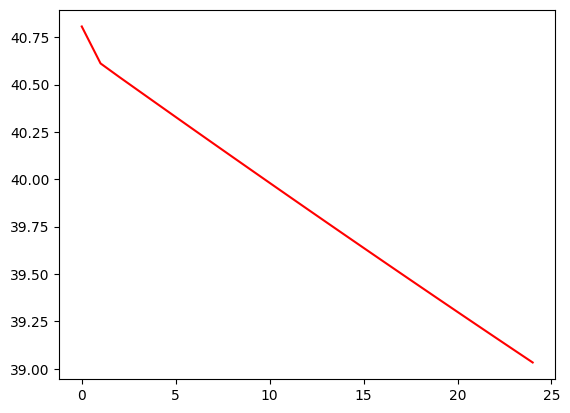

  5%|▌         | 25/500 [00:12<03:49,  2.07it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.86172672418654
Dataset Name:  inj_cora , AUC Score (contextual):  84.18661323513484
Dataset Name:  inj_cora , AUC Score (structural):  43.65157586916496
Dataset Name:  inj_cora , AUC Score (joint-type):  46.98202101158886
Dataset Name:  inj_cora , AUC Score (structure type):  44.934764527809435
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  46.98202101158886
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


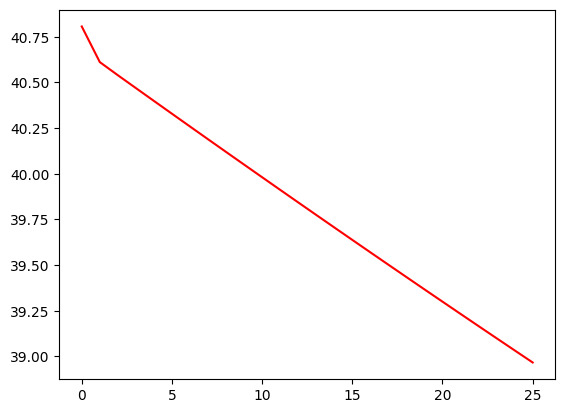

  5%|▌         | 26/500 [00:12<04:12,  1.88it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.18626289967857
Dataset Name:  inj_cora , AUC Score (contextual):  84.0604353947796
Dataset Name:  inj_cora , AUC Score (structural):  44.40701830390989
Dataset Name:  inj_cora , AUC Score (joint-type):  47.71905122928625
Dataset Name:  inj_cora , AUC Score (structure type):  45.70235598208859
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.71905122928625
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


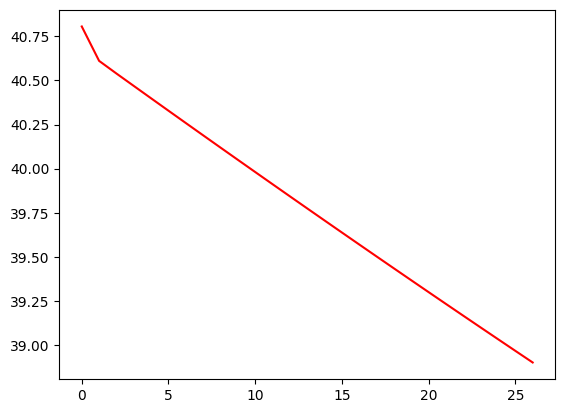

  5%|▌         | 27/500 [00:13<04:04,  1.93it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.08955055546157
Dataset Name:  inj_cora , AUC Score (contextual):  84.00574027943246
Dataset Name:  inj_cora , AUC Score (structural):  44.275966641394994
Dataset Name:  inj_cora , AUC Score (joint-type):  47.988194519657746
Dataset Name:  inj_cora , AUC Score (structure type):  45.768165537636065
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.988194519657746
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


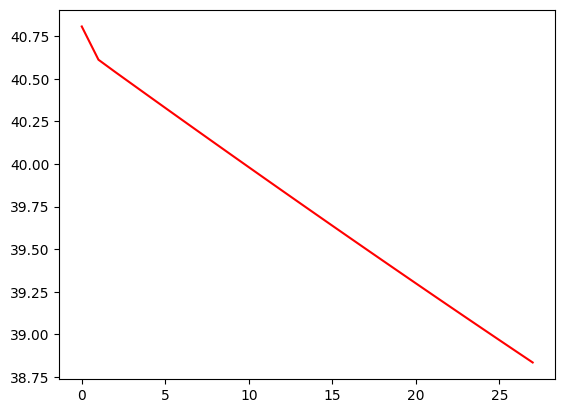

  6%|▌         | 28/500 [00:13<03:59,  1.97it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.25985450854338
Dataset Name:  inj_cora , AUC Score (contextual):  84.10971515217157
Dataset Name:  inj_cora , AUC Score (structural):  44.5050362828983
Dataset Name:  inj_cora , AUC Score (joint-type):  48.10300010830716
Dataset Name:  inj_cora , AUC Score (structure type):  45.946831479930886
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.10300010830716
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


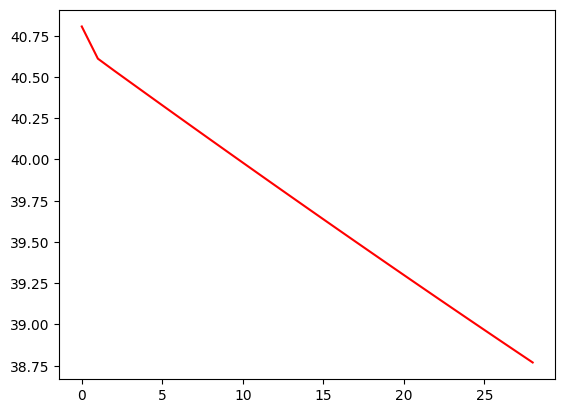

  6%|▌         | 29/500 [00:14<03:55,  2.00it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.32583319235323
Dataset Name:  inj_cora , AUC Score (contextual):  84.15033033683525
Dataset Name:  inj_cora , AUC Score (structural):  44.594389689158454
Dataset Name:  inj_cora , AUC Score (joint-type):  48.21943030434312
Dataset Name:  inj_cora , AUC Score (structure type):  46.05352697211635
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.21943030434312
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


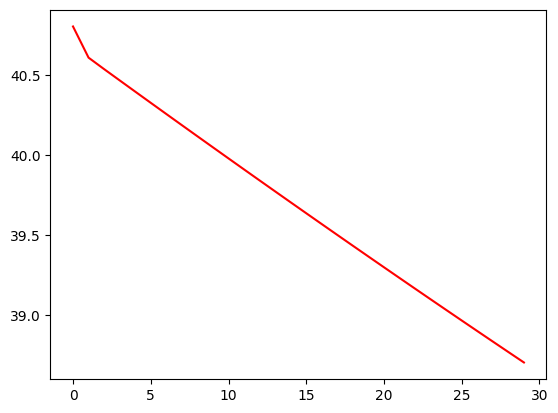

  6%|▌         | 30/500 [00:14<03:50,  2.04it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.920092482941406
Dataset Name:  inj_cora , AUC Score (contextual):  84.21802231127478
Dataset Name:  inj_cora , AUC Score (structural):  43.748510776562334
Dataset Name:  inj_cora , AUC Score (joint-type):  48.02880970432145
Dataset Name:  inj_cora , AUC Score (structure type):  45.52088963317473
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.02880970432145
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


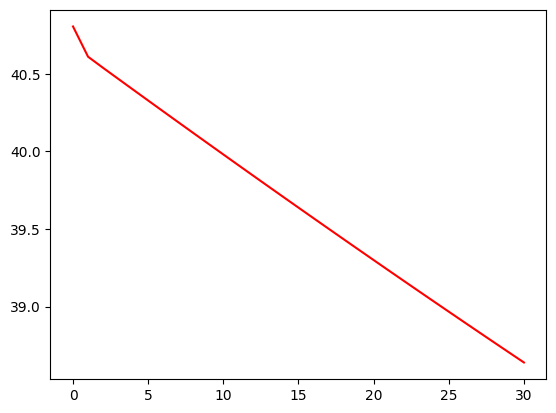

  6%|▌         | 31/500 [00:15<03:46,  2.07it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.5122088761067
Dataset Name:  inj_cora , AUC Score (contextual):  84.11350590274017
Dataset Name:  inj_cora , AUC Score (structural):  45.002166143182066
Dataset Name:  inj_cora , AUC Score (joint-type):  48.5318964583559
Dataset Name:  inj_cora , AUC Score (structure type):  46.4321419470107
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.5318964583559
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


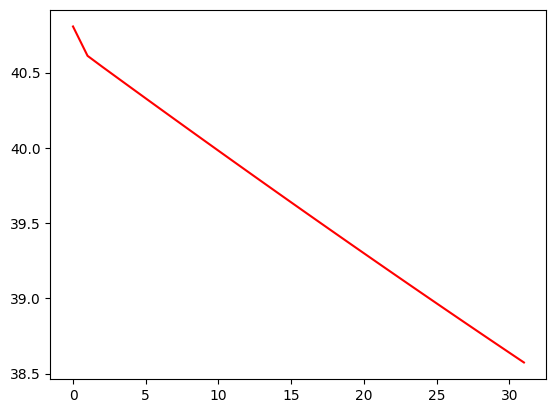

  6%|▋         | 32/500 [00:15<03:45,  2.07it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.16032256245417
Dataset Name:  inj_cora , AUC Score (contextual):  84.13029351240117
Dataset Name:  inj_cora , AUC Score (structural):  44.3165818260587
Dataset Name:  inj_cora , AUC Score (joint-type):  48.36618650492797
Dataset Name:  inj_cora , AUC Score (structure type):  46.000879327678376
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.36618650492797
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


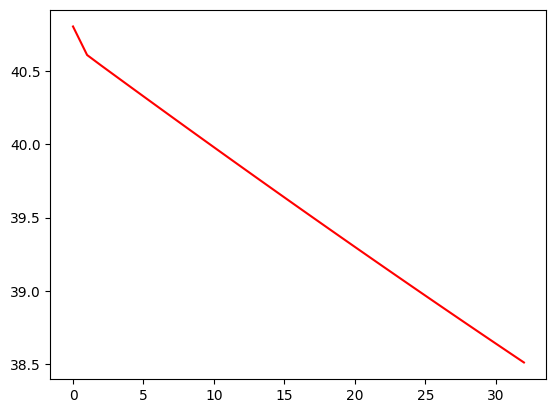

  7%|▋         | 33/500 [00:16<03:43,  2.09it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.30637793943495
Dataset Name:  inj_cora , AUC Score (contextual):  84.06909996750785
Dataset Name:  inj_cora , AUC Score (structural):  44.6599155204159
Dataset Name:  inj_cora , AUC Score (joint-type):  48.519711902956786
Dataset Name:  inj_cora , AUC Score (structure type):  46.255856350342064
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.519711902956786
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


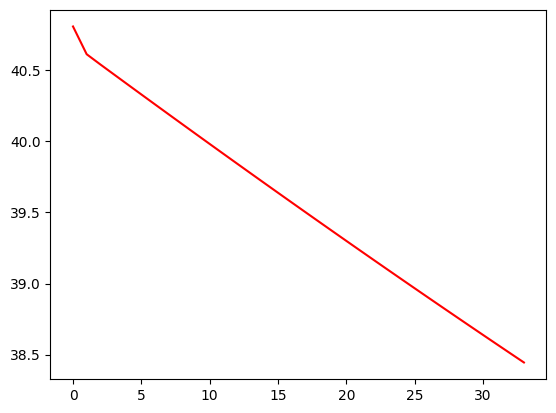

  7%|▋         | 34/500 [00:16<03:41,  2.10it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.40168048271585
Dataset Name:  inj_cora , AUC Score (contextual):  84.06260153796167
Dataset Name:  inj_cora , AUC Score (structural):  44.84999458464205
Dataset Name:  inj_cora , AUC Score (joint-type):  48.59985920069316
Dataset Name:  inj_cora , AUC Score (structure type):  46.392796234013176
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.59985920069316
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


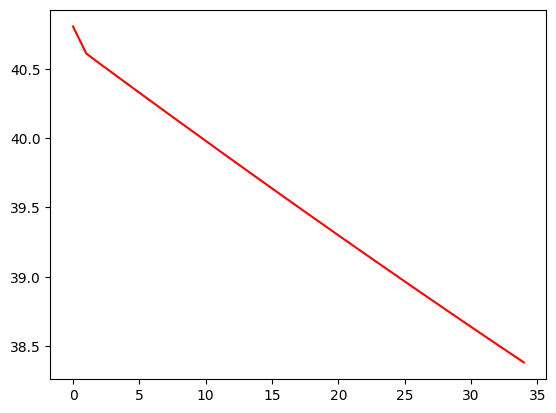

  7%|▋         | 35/500 [00:17<03:41,  2.10it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.29989285512886
Dataset Name:  inj_cora , AUC Score (contextual):  84.08480450557781
Dataset Name:  inj_cora , AUC Score (structural):  44.63121412325354
Dataset Name:  inj_cora , AUC Score (joint-type):  48.42061085237734
Dataset Name:  inj_cora , AUC Score (structure type):  46.185846184866044
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.42061085237734
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


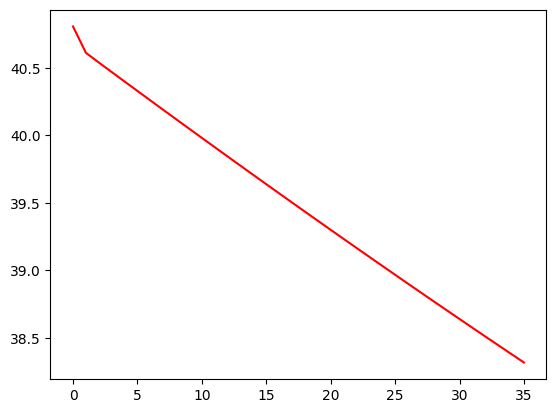

  7%|▋         | 36/500 [00:17<03:41,  2.09it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.45440703772627
Dataset Name:  inj_cora , AUC Score (contextual):  84.07668146864508
Dataset Name:  inj_cora , AUC Score (structural):  44.93339109715152
Dataset Name:  inj_cora , AUC Score (joint-type):  48.32340517708221
Dataset Name:  inj_cora , AUC Score (structure type):  46.2954821040015
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.22668688400303
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.32340517708221
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


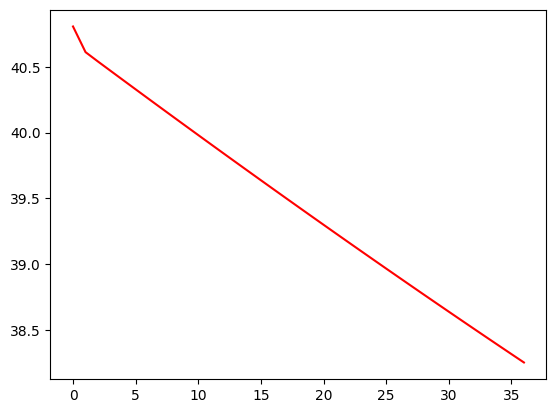

  7%|▋         | 37/500 [00:17<03:40,  2.10it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.09265211752101
Dataset Name:  inj_cora , AUC Score (contextual):  84.2321022419582
Dataset Name:  inj_cora , AUC Score (structural):  44.076139932849564
Dataset Name:  inj_cora , AUC Score (joint-type):  48.153904473085674
Dataset Name:  inj_cora , AUC Score (structure type):  45.76144456175036
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.2321022419582
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.153904473085674
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


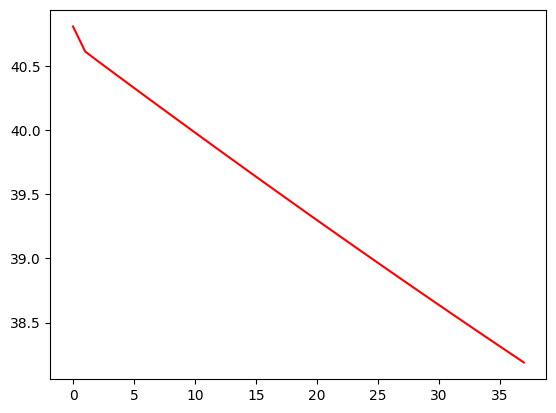

  8%|▊         | 38/500 [00:18<03:41,  2.09it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  64.07235098404105
Dataset Name:  inj_cora , AUC Score (contextual):  84.29654500162461
Dataset Name:  inj_cora , AUC Score (structural):  43.96566663056428
Dataset Name:  inj_cora , AUC Score (joint-type):  48.087295570237195
Dataset Name:  inj_cora , AUC Score (structure type):  45.66987126530773
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.29654500162461
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.087295570237195
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


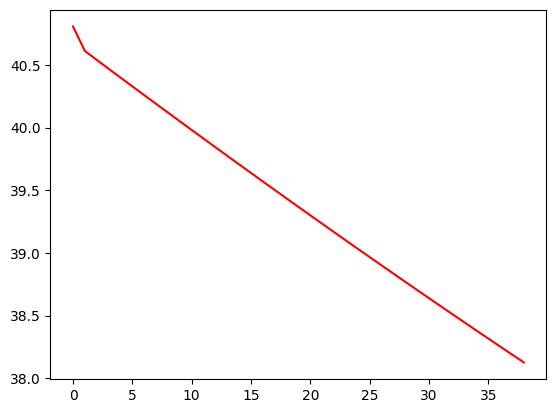

  8%|▊         | 39/500 [00:18<03:40,  2.09it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.75119833079569
Dataset Name:  inj_cora , AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora , AUC Score (structural):  43.312574461171884
Dataset Name:  inj_cora , AUC Score (joint-type):  47.79974006281815
Dataset Name:  inj_cora , AUC Score (structure type):  45.1840007169041
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.79974006281815
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


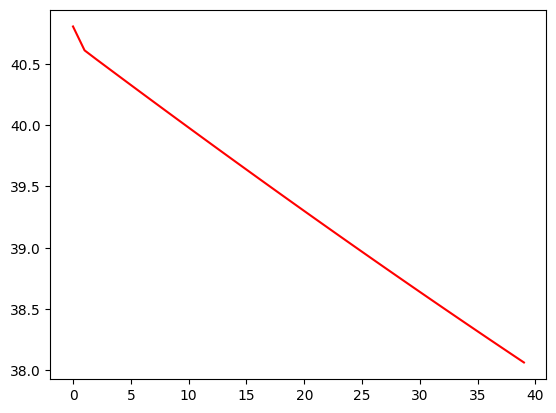

  8%|▊         | 40/500 [00:19<03:41,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.6584334291998
Dataset Name:  inj_cora , AUC Score (contextual):  84.31441568287664
Dataset Name:  inj_cora , AUC Score (structural):  43.13765839922019
Dataset Name:  inj_cora , AUC Score (joint-type):  47.570128885519324
Dataset Name:  inj_cora , AUC Score (structure type):  44.97649058643315
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.570128885519324
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


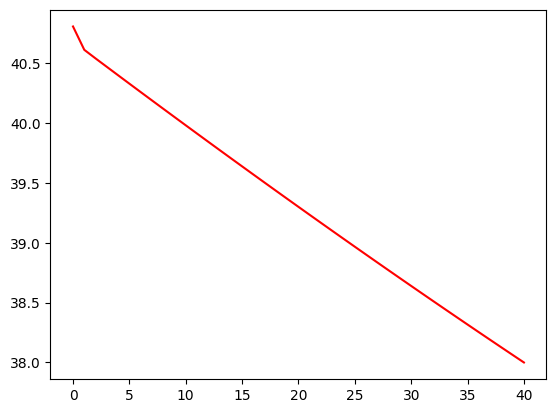

  8%|▊         | 41/500 [00:19<03:41,  2.07it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.65829244910619
Dataset Name:  inj_cora , AUC Score (contextual):  84.1714502328604
Dataset Name:  inj_cora , AUC Score (structural):  43.27602079497455
Dataset Name:  inj_cora , AUC Score (joint-type):  47.47102783493989
Dataset Name:  inj_cora , AUC Score (structure type):  44.99595341243549
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.47102783493989
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


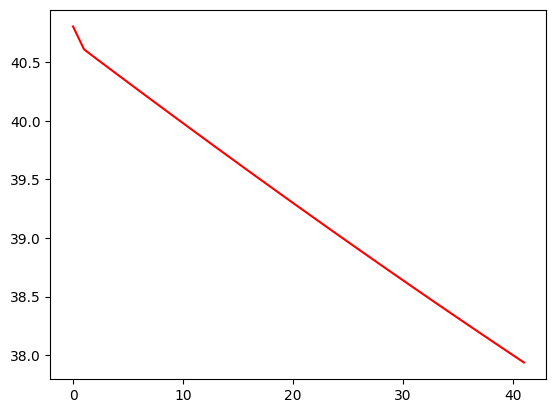

  8%|▊         | 42/500 [00:20<03:40,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.81097389048666
Dataset Name:  inj_cora , AUC Score (contextual):  83.98895266977148
Dataset Name:  inj_cora , AUC Score (structural):  43.754467670313005
Dataset Name:  inj_cora , AUC Score (joint-type):  47.63700855626557
Dataset Name:  inj_cora , AUC Score (structure type):  45.32780159679186
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.63700855626557
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


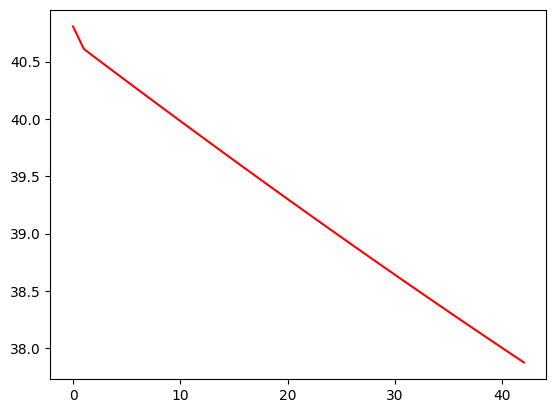

  9%|▊         | 43/500 [00:20<03:38,  2.09it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.84072069023854
Dataset Name:  inj_cora , AUC Score (contextual):  83.80374742770496
Dataset Name:  inj_cora , AUC Score (structural):  43.995721867215416
Dataset Name:  inj_cora , AUC Score (joint-type):  47.80569695656883
Dataset Name:  inj_cora , AUC Score (structure type):  45.53895225586755
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.80569695656883
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


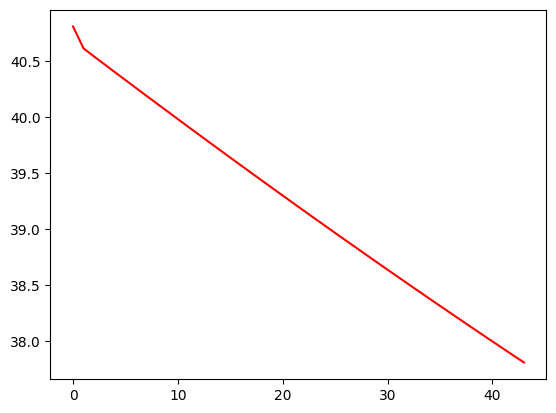

  9%|▉         | 44/500 [00:21<03:37,  2.10it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.754863813229576
Dataset Name:  inj_cora , AUC Score (contextual):  83.75771688508611
Dataset Name:  inj_cora , AUC Score (structural):  43.875230152713094
Dataset Name:  inj_cora , AUC Score (joint-type):  47.94351781652767
Dataset Name:  inj_cora , AUC Score (structure type):  45.545953272415154
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.94351781652767
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


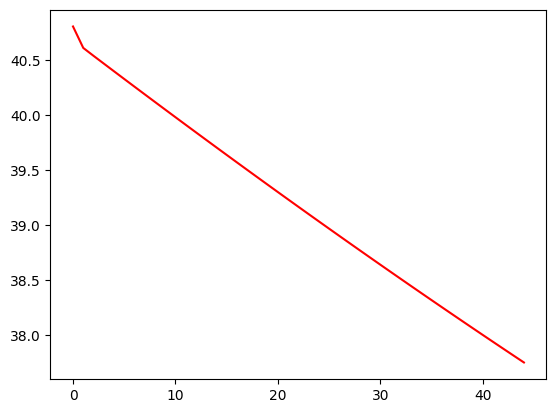

  9%|▉         | 45/500 [00:21<03:36,  2.10it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.672531438560874
Dataset Name:  inj_cora , AUC Score (contextual):  83.71656016462687
Dataset Name:  inj_cora , AUC Score (structural):  43.757716885086104
Dataset Name:  inj_cora , AUC Score (joint-type):  48.07592331853135
Dataset Name:  inj_cora , AUC Score (structure type):  45.554494512603235
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.07592331853135
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


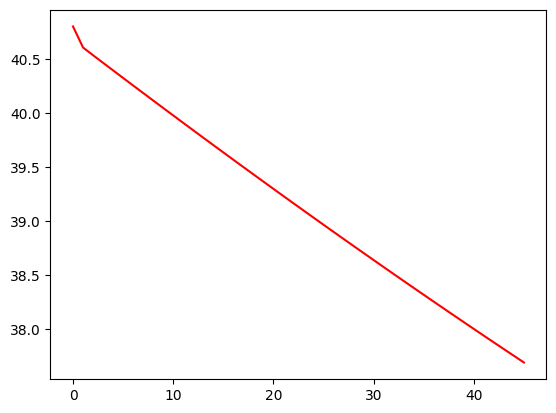

  9%|▉         | 46/500 [00:22<03:35,  2.11it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.58315005921165
Dataset Name:  inj_cora , AUC Score (contextual):  83.68298494530487
Dataset Name:  inj_cora , AUC Score (structural):  43.618000649842955
Dataset Name:  inj_cora , AUC Score (joint-type):  48.15092602621033
Dataset Name:  inj_cora , AUC Score (structure type):  45.521029653505686
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.15092602621033
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


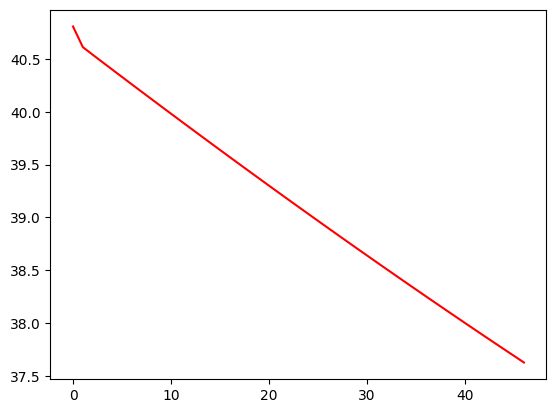

  9%|▉         | 47/500 [00:22<03:35,  2.10it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.488693396492415
Dataset Name:  inj_cora , AUC Score (contextual):  83.64020361745912
Dataset Name:  inj_cora , AUC Score (structural):  43.47882595039532
Dataset Name:  inj_cora , AUC Score (joint-type):  48.20887035633056
Dataset Name:  inj_cora , AUC Score (structure type):  45.47902355422008
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.20887035633056
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


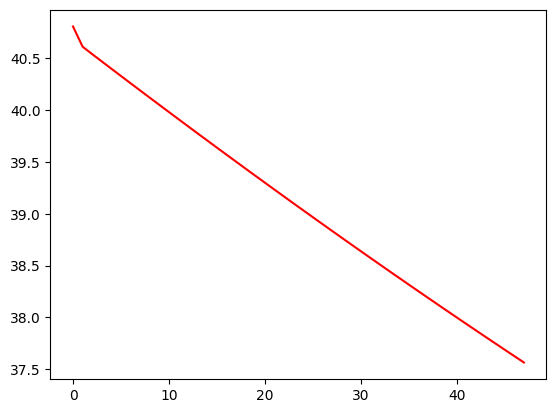

 10%|▉         | 48/500 [00:23<03:35,  2.10it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.48756555574353
Dataset Name:  inj_cora , AUC Score (contextual):  83.59363153904474
Dataset Name:  inj_cora , AUC Score (structural):  43.52160727824109
Dataset Name:  inj_cora , AUC Score (joint-type):  48.24650709411892
Dataset Name:  inj_cora , AUC Score (structure type):  45.519769470527116
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.24650709411892
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


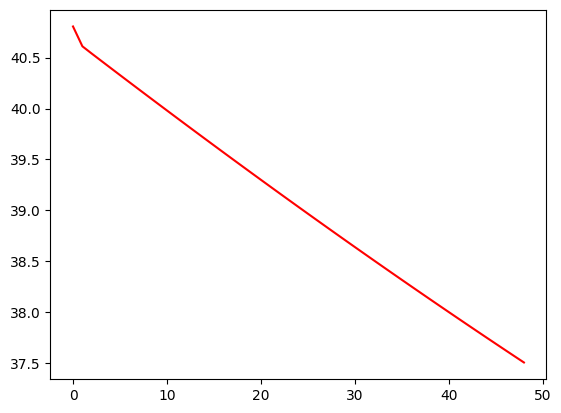

 10%|▉         | 49/500 [00:23<03:36,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.52365645970789
Dataset Name:  inj_cora , AUC Score (contextual):  83.50698581176216
Dataset Name:  inj_cora , AUC Score (structural):  43.67865265894076
Dataset Name:  inj_cora , AUC Score (joint-type):  48.26464854326871
Dataset Name:  inj_cora , AUC Score (structure type):  45.61092270597691
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.26464854326871
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


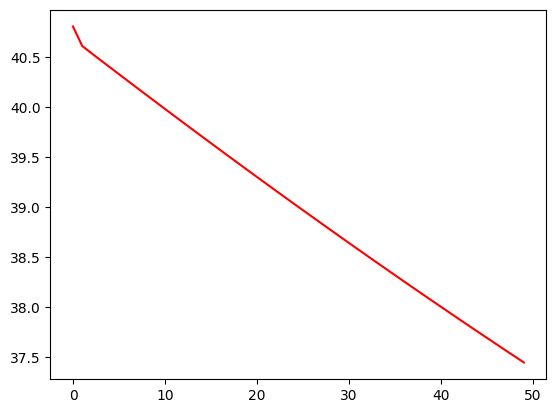

 10%|█         | 50/500 [00:24<03:36,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.52252861895901
Dataset Name:  inj_cora , AUC Score (contextual):  83.43171233618543
Dataset Name:  inj_cora , AUC Score (structural):  43.74634463338026
Dataset Name:  inj_cora , AUC Score (joint-type):  48.229448716560164
Dataset Name:  inj_cora , AUC Score (structure type):  45.62772514569116
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.229448716560164
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


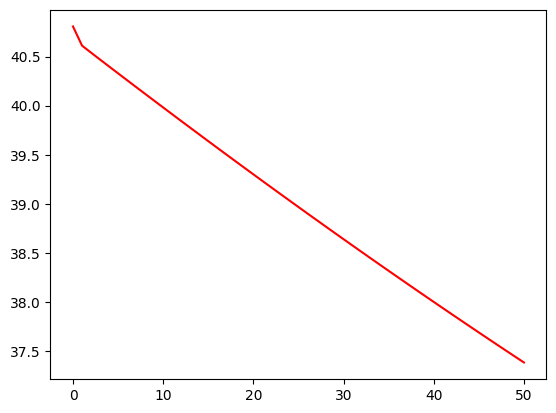

 10%|█         | 51/500 [00:24<03:35,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.56736028872723
Dataset Name:  inj_cora , AUC Score (contextual):  83.37051879129211
Dataset Name:  inj_cora , AUC Score (structural):  43.890934690783055
Dataset Name:  inj_cora , AUC Score (joint-type):  48.19912271201126
Dataset Name:  inj_cora , AUC Score (structure type):  45.687933888000536
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.19912271201126
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


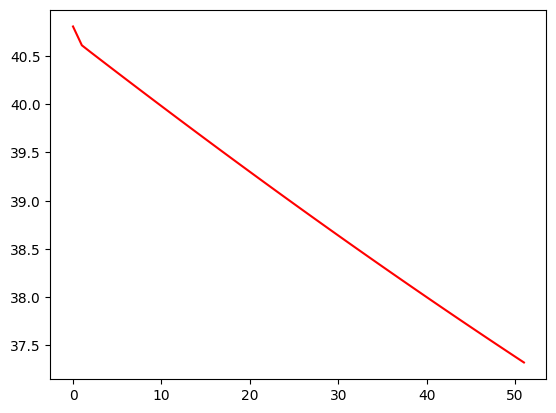

 10%|█         | 52/500 [00:25<03:34,  2.09it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.607821575593526
Dataset Name:  inj_cora , AUC Score (contextual):  83.31934365861584
Dataset Name:  inj_cora , AUC Score (structural):  44.018737138524855
Dataset Name:  inj_cora , AUC Score (joint-type):  48.18775046030543
Dataset Name:  inj_cora , AUC Score (structure type):  45.74758254898612
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.18775046030543
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


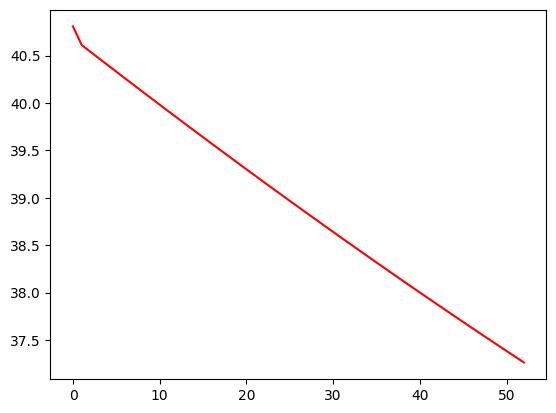

 11%|█         | 53/500 [00:25<03:34,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.668161055658935
Dataset Name:  inj_cora , AUC Score (contextual):  83.24000866457274
Dataset Name:  inj_cora , AUC Score (structural):  44.210170042239795
Dataset Name:  inj_cora , AUC Score (joint-type):  48.15092602621033
Dataset Name:  inj_cora , AUC Score (structure type):  45.82753415795974
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.15092602621033
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


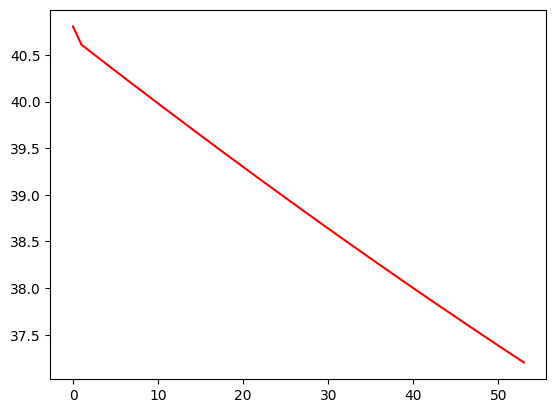

 11%|█         | 54/500 [00:26<03:33,  2.09it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.721310550950214
Dataset Name:  inj_cora , AUC Score (contextual):  83.18314740604355
Dataset Name:  inj_cora , AUC Score (structural):  44.36369544026861
Dataset Name:  inj_cora , AUC Score (joint-type):  48.1801689591682
Dataset Name:  inj_cora , AUC Score (structure type):  45.92092771870476
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.1801689591682
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


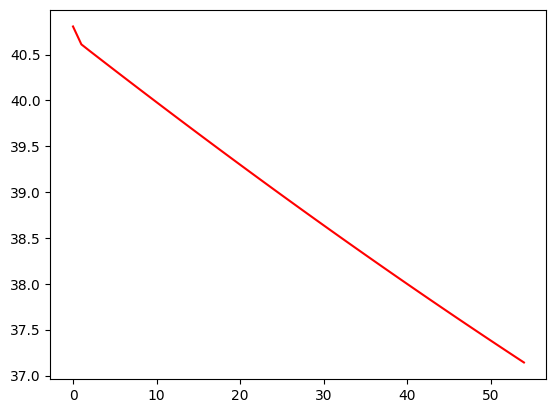

 11%|█         | 55/500 [00:26<03:33,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.7644504595951
Dataset Name:  inj_cora , AUC Score (contextual):  83.1040831798982
Dataset Name:  inj_cora , AUC Score (structural):  44.522365428354824
Dataset Name:  inj_cora , AUC Score (joint-type):  48.204538069966425
Dataset Name:  inj_cora , AUC Score (structure type):  46.01502138110454
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.204538069966425
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


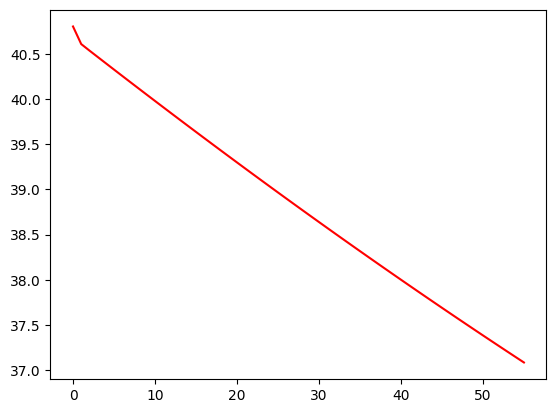

 11%|█         | 56/500 [00:27<03:33,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.82464895956691
Dataset Name:  inj_cora , AUC Score (contextual):  83.03747427704971
Dataset Name:  inj_cora , AUC Score (structural):  44.70459222354597
Dataset Name:  inj_cora , AUC Score (joint-type):  48.210494963717096
Dataset Name:  inj_cora , AUC Score (structure type):  46.111495389130496
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.210494963717096
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


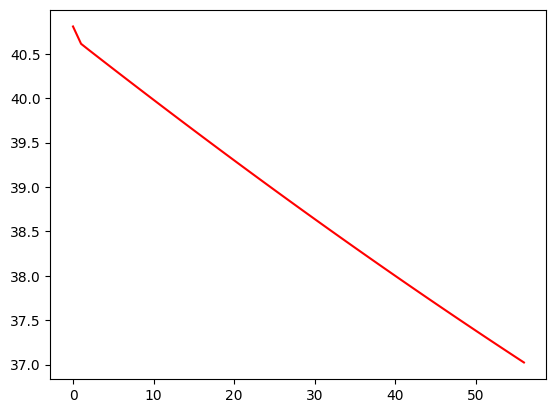

 11%|█▏        | 57/500 [00:27<03:32,  2.08it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.858343201939896
Dataset Name:  inj_cora , AUC Score (contextual):  82.96382540885952
Dataset Name:  inj_cora , AUC Score (structural):  44.839705404527244
Dataset Name:  inj_cora , AUC Score (joint-type):  48.22511643019604
Dataset Name:  inj_cora , AUC Score (structure type):  46.18864659148508
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.22511643019604
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


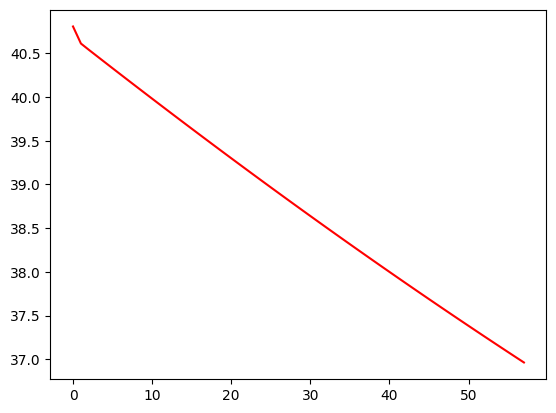

 12%|█▏        | 58/500 [00:28<03:33,  2.07it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.883578638696214
Dataset Name:  inj_cora , AUC Score (contextual):  82.87772121737245
Dataset Name:  inj_cora , AUC Score (structural):  44.97319397812195
Dataset Name:  inj_cora , AUC Score (joint-type):  48.24190403985703
Dataset Name:  inj_cora , AUC Score (structure type):  46.26551775317776
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.24190403985703
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


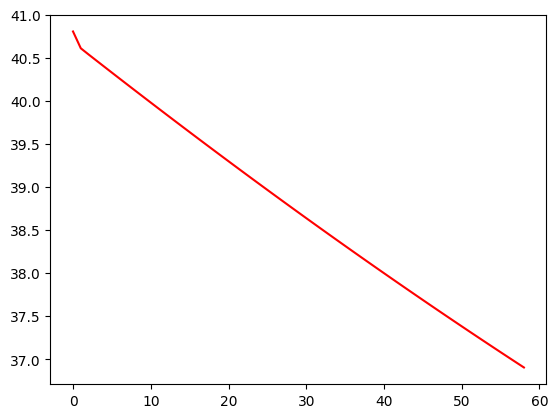

 12%|█▏        | 59/500 [00:28<03:32,  2.07it/s]

Dataset Name:  inj_cora , AUC Score(benchmark/combined):  63.912338577792816
Dataset Name:  inj_cora , AUC Score (contextual):  82.80542618867108
Dataset Name:  inj_cora , AUC Score (structural):  45.10235026535254
Dataset Name:  inj_cora , AUC Score (joint-type):  48.27683309866782
Dataset Name:  inj_cora , AUC Score (structure type):  46.351770277044224
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  68.8507302768849
Dataset Name:  inj_cora  Best AUC Score (contextual):  84.3236217914004
Dataset Name:  inj_cora  Best AUC Score (structural):  56.42153146322973
Dataset Name:  inj_cora  Best AUC Score (joint-type):  48.27683309866782
Dataset Name:  inj_cora  Best AUC Score (structure type):  52.60563833868678


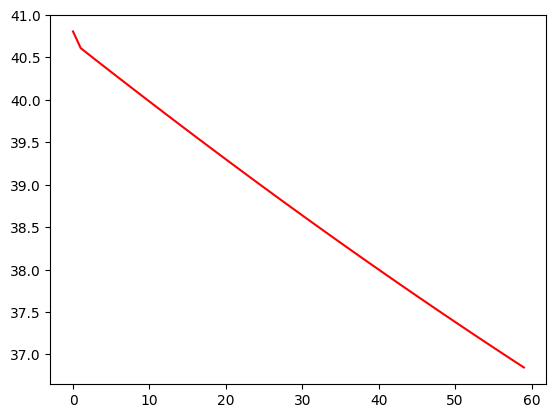

 12%|█▏        | 60/500 [00:29<03:33,  2.06it/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
parser = argparse.ArgumentParser(description='parameters')
parser.add_argument('-f')
parser.add_argument('--dataset', type=str, default="inj_cora")
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--epoch_num', type=int, default=500)
parser.add_argument('--lambda_loss1', type=float, default=1e-2) #neighbor reconstruction loss weight
parser.add_argument('--lambda_loss2', type=float, default=0.1) #feature loss weight
parser.add_argument('--lambda_loss3', type=float, default=0.8) #degree loss weight
parser.add_argument('--sample_size', type=int, default=10)
parser.add_argument('--dimension', type=int, default=128)
parser.add_argument('--encoder', type=str, default="GCN")
parser.add_argument('--loss_step', type=int, default=5000)
parser.add_argument('--real_loss', type=bool, default=False) #use real loss or adaptive loss
parser.add_argument('--neigh_loss', type=str, default="KL")
parser.add_argument('--h_loss_weight', type=float, default=1.0)#adaptive loss weight for h_loss
parser.add_argument('--feature_loss_weight', type=float, default=2.5) #adaptive loss weight for feature loss
parser.add_argument('--degree_loss_weight', type=float, default=0)#adaptive loss weight for degree loss
parser.add_argument('--calculate_contextual', type=bool, default=True)
parser.add_argument('--contextual_n', type=int, default=70)
parser.add_argument('--contextual_k', type=int, default=10)
parser.add_argument('--calculate_structural', type=bool, default=True)
parser.add_argument('--structural_n', type=int, default=70)
parser.add_argument('--structural_m', type=int, default=10)
parser.add_argument('--use_combine_outlier', type=bool, default=False)
parser.add_argument('--plot_loss', type=bool, default=True)
parser.add_argument('--normalize_feat', type=bool, default=False)



args = parser.parse_args()

print("GAD-NR: Graph Anomaly Detection via Neighborhood Reconstruction")
print("Dataset: ", args.dataset, "lr:", args.lr, "lambda_loss1 (neighbor):",args.lambda_loss1, "lambda_loss2 (feature):", args.lambda_loss2, "lambda_loss3 (degree):", args.lambda_loss3, "sample_size:", args.sample_size, "dimension:",args.dimension, "encoder:", args.encoder, "loss_step:", args.loss_step,"real_loss:", args.real_loss, "h_loss_weight:",args.h_loss_weight,"feature_loss_weight",args.feature_loss_weight,"degree_loss_weight:",args.degree_loss_weight,
"calculate_contextual",args.calculate_contextual,"calculate_structural",args.calculate_structural)


dataset_str = args.dataset
train_real_datasets(dataset_str=dataset_str, lr=args.lr, epoch_num=args.epoch_num, lambda_loss1=args.lambda_loss1, 
lambda_loss2=args.lambda_loss2, lambda_loss3=args.lambda_loss3, encoder=args.encoder, sample_size=args.sample_size, loss_step=args.loss_step, 
hidden_dim=args.dimension,real_loss=args.real_loss,calculate_contextual=args.calculate_contextual,calculate_structural=args.calculate_structural)

In [7]:
import torch 

m = torch.rand(5,3)
s = torch.rand(5,3)

n_list = []

for i in range(10):
    a = torch.normal(mean=m, std=s)
    a = a.unsqueeze(dim=0)
    n_list.append(a)

n_list = torch.cat(n_list,dim=0)
print(n_list.shape)

torch.Size([10, 5, 3])


In [8]:
a.shape

torch.Size([1, 5, 3])

In [9]:
import torch
a = torch.FloatTensor([10]* 100)
print(a.shape)

torch.Size([100])


8 = 71.04
16 = 
32 = 
64 = 
128 = 

In [15]:
# w/o feature
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  72.93125810635537
Dataset Name:  inj_cora  Best AUC Score (contextual):  74.63392180223111
Dataset Name:  inj_cora  Best AUC Score (structural):  93.80483049929602
Dataset Name:  inj_cora  Best AUC Score (joint-type):  52.578793458247596
Dataset Name:  inj_cora  Best AUC Score (structure type):  73.84706479445103

Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  73.29752438955619
Dataset Name:  inj_cora  Best AUC Score (contextual):  63.87631322430411
Dataset Name:  inj_cora  Best AUC Score (structural):  93.92450991010504
Dataset Name:  inj_cora  Best AUC Score (joint-type):  47.71011588866023
Dataset Name:  inj_cora  Best AUC Score (structure type):  72.61808436036988


# w/o degree
Dataset Name:  inj_cora  Best AUC Score(benchmark/combined):  65.79315400665425
Dataset Name:  inj_cora  Best AUC Score (contextual):  75.1982021011589
Dataset Name:  inj_cora  Best AUC Score (structural):  62.06541752409834
Dataset Name:  inj_cora  Best AUC Score (joint-type):  45.967724466587235
Dataset Name:  inj_cora  Best AUC Score (structure type):  55.960074437489425




# w/o neighbor

SyntaxError: invalid syntax (3520964218.py, line 2)